In [1]:
import numpy as np
import sympy
import matplotlib.pyplot as plt
import base64
import pickle
from sympy import symbols, MatrixSymbol, lambdify, Matrix, pprint

from scipy.optimize import minimize
from matplotlib.ticker import FuncFormatter
from sympy import symbols, MatrixSymbol, lambdify
from matplotlib import cm
import random
import matplotlib.colors as mcolors
import scipy
import time
from pathlib import Path
import os
import ast
import pandas as pd
from pathlib import Path
from matplotlib.ticker import ScalarFormatter


import pennylane as qml
from functools import partial
from qiskit.circuit.library import *
from qiskit import *
from qiskit.quantum_info import *
import autograd
from pennylane.wires import Wires
import matplotlib.cm as cm
import base64
from qiskit import *
from qiskit.quantum_info import *
import os
import pickle
import re
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

global_cache_data_digital = None
global_processed_files_digital = None

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [22]:
import os
import pickle
def inspect_cache_file(cache_path):
    """Inspect the contents of the cached_results.pkl file and print the number of processed files for each N_ctrl."""
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            try:
                cached_data, processed_files = pickle.load(f)
                print(f"Cache file loaded successfully from: {cache_path}")

                # Print the total number of processed files
                print(f"\n---- Total Number of Processed Files: {len(processed_files)} ----")

                print("\n---- Number of Processed Files for Each N_ctrl ----")
                for N_ctrl, gates_data in cached_data.items():
                    # Calculate the number of processed files for this N_ctrl
                    num_processed_for_ctrl = sum(
                        len(runs_data) for gate_data in gates_data.values()
                        for reservoir_data in gate_data.values()
                        for runs_data in reservoir_data.values()
                    )
                    print(f"N_ctrl={N_ctrl}: {num_processed_for_ctrl} processed files.")

                    # Look for trotter steps greater than 20
                    print(f"\nInspecting trotter steps > 20 for N_ctrl={N_ctrl}:")
                    for gate, reservoir_data in gates_data.items():
                        for reservoir_count, trotter_data in reservoir_data.items():
                            for trotter_step, runs_data in trotter_data.items():
                                if trotter_step > 20:
                                    print(f" - Gate: {gate}, Reservoir: {reservoir_count}, Trotter_Step: {trotter_step}, Files: {len(runs_data)}")

            except (EOFError, pickle.UnpicklingError) as e:
                print(f"Error loading cache file: {e}")
    else:
        print(f"Cache file not found: {cache_path}")

# Path to your cache file
cache_path = '/Users/sophieblock/QRCCapstone/analog_results_trainable_global/trainsize_20/0/cached_results.pkl'

# Inspect the cache file
inspect_cache_file(cache_path)


Cache file loaded successfully from: /Users/sophieblock/QRCCapstone/analog_results_trainable_global/trainsize_20/0/cached_results.pkl

---- Total Number of Processed Files: 721 ----

---- Number of Processed Files for Each N_ctrl ----
N_ctrl=3: 405 processed files.

Inspecting trotter steps > 20 for N_ctrl=3:
 - Gate: U3_0, Reservoir: 1, Trotter Step: 25, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 30, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 35, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 40, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 21, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 24, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 27, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 33, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 36, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 39, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 28, Files: 1
 - Gate: U3_0, Reservoir: 1, Trotter Step: 32, Files: 1
 - Gate: U3_0, Re

In [50]:

def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                # Attempt to load the pickle file
                df = pickle.load(f)
                
            return True
        else:
            return False
    except EOFError:
        return False
def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0
def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        costs = np.asarray([float(i) for i in df['costs'][0]], dtype=np.float64)
        grads_per_epoch = [np.asarray(i, dtype=np.float64) for i in df['grads_per_epoch'][0]]

        fidelity =df['avg_fidelity'][0]
        num_params = 3 + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        try:
            test_results =  np.asarray(df['fidelities'][0], dtype=np.float64)
        except KeyError:
            
            test_results =  np.asarray(df['testing_results'][0], dtype=np.float64)
        num_epochs = df['epochs'][0]
        return costs, fidelity, num_params, test_results,grads_per_epoch


def get_cached_data(base_path):
    """Load cached data and list of processed files from cache stored in the base_path."""
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        print(f"Loaded {len(processed_files)} processed files.")
        return cached_data, processed_files
    else:
        return {}, set()

def get_cached_data_once_digital(base_path):
    """Load cached data only once and keep it in memory for future runs for the digital model."""
    global global_cache_data_digital, global_processed_files_digital
    start_time = time.time()

    # If the cache has already been loaded, skip re-loading
    if global_cache_data_digital is not None and global_processed_files_digital is not None:
        return global_cache_data_digital, global_processed_files_digital

    # Load the cache from disk (only happens once)
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            global_cache_data_digital, global_processed_files_digital = pickle.load(f)
        
        # Filter the cache to only include files from the correct base path
        global_processed_files_digital = set(
            file for file in global_processed_files_digital if file.startswith(base_path)
        )
        return global_cache_data_digital, global_processed_files_digital
    else:
        global_cache_data_digital = {}
        global_processed_files_digital = set()
        return global_cache_data_digital, global_processed_files_digital
    
def save_cached_data(base_path, cached_data, processed_files):
    """Save cached data and list of processed files to cache stored in the base_path."""
    cache_file = os.path.join(base_path, f'cached_results.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)

def update_cache_with_new_data(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Update cache with new key/values without reprocessing already processed files."""
    print(f"Processing for N_ctrl = {N_ctrl}")
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                for bath_status in ['bath_True', 'bath_False/testing_preopt/']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)

                                    # Count data runs already in cache
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    num_data_runs = len(cached_trotter_data)

                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            
                                            # Normalize the file path to ensure consistency in checking
                                            pickle_file = os.path.normpath(pickle_file)

                                            # Extract just the data_run_<i> part from the file name
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                # Update the run field in cached data if missing
                                                for cached_result in cached_trotter_data:
                                                    if 'run' not in cached_result or 'gate' not in cached_result or cached_result['run'] != run:
                                                        cached_result['run'] = run
                                                        cached_result['gate'] = gate
                                                continue

                                            # Process new file
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results, grads_per_epoch = read_jax_file(pickle_file, gate)
                                                
                                                

                                                # Store the new data point
                                                if gate not in cached_data[N_ctrl]:
                                                    cached_data[N_ctrl][gate] = {}
                                                if reservoir_count not in cached_data[N_ctrl][gate]:
                                                    cached_data[N_ctrl][gate][reservoir_count] = {}
                                                if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                     
                                                
                                                num_data_runs += 1  # Increment the number of data runs
                                                # Extract just the data_run_<i> part from the file name
                                                run = os.path.basename(pickle_file).replace('.pickle', '')

                                                # Check if this new file has a better fidelity
                                                if fidelity > current_best_fidelity:
                                                    current_best_fidelity = fidelity
                                                    current_best_data_point = {
                                                        'costs': costs,
                                                        'gate': gate,
                                                        'fidelity': fidelity,
                                                        'test_results': test_results,
                                                        'param_count': num_params,
                                                        'run': run,
                                                        'num_data_runs': num_data_runs,  # Track the number of data runs
                                                        'grads_per_epoch':grads_per_epoch,
                                                    }

                                                # Update cache with new or modified data point
                                                cached_data[N_ctrl][gate][reservoir_count][trotter_step].append(data_point)
                                                processed_files.add(pickle_file)  # Mark file as processed

    print(f"Cache updated for N_ctrl={N_ctrl}")
    return cached_data, processed_files
def process_new_files_digital(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Process new files that haven't been processed before, and update cache with the best fidelity."""
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                # Ensure that N_ctrl is a top-level key in the cache
                if N_ctrl not in cached_data:
                    cached_data[N_ctrl] = {}

                for bath_status in ['bath_False']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        print(f"not a path: {trotter_path}")
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    current_best_fidelity = float('-inf')  # Set initial best fidelity as lowest possible value
                                    current_best_data_point = None
                                    num_data_runs = 0
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    missing_paths = 0  # Counter for entries with missing paths

                                    # Retrofit 'path' for cached data if missing
                                    for data_point in cached_trotter_data:
                                        if 'path' not in data_point or data_point['path'] is None:
                                            run = data_point.get('run', None)
                                            if run:
                                                potential_file_path = os.path.join(trotter_path, f"{run}.pickle")
                                                if not potential_file_path.startswith(base_path):
                                                    print(f"Incorrect filepath: {potential_file_path}")
                                                
                                                if os.path.exists(potential_file_path):
                                                    data_point['path'] = potential_file_path
                                                else:
                                                    missing_paths += 1
                                    # Check if there's already cached data for this trotter step
                                    # cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    # if cached_trotter_data:
                                    #     current_best_data_point = cached_trotter_data[0]  # Assuming one best result per trotter step
                                    #     current_best_fidelity = np.mean(current_best_data_point['fidelity'])
                                    #     num_data_runs = current_best_data_point.get('num_data_runs', 0)
                                    if missing_paths > 0:
                                        print(
                                            f"[WARNING] {missing_paths} data points missing files for "
                                            f"N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step}"
                                        )
                                    # Now process the new files and compare with cached results
                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.join(trotter_path, file)
                                            
                                            # Normalize the file path to ensure consistency in checking
                                            pickle_file = os.path.normpath(pickle_file)
                                           
                                            # Ensure the file belongs to the correct base path
                                            if not pickle_file.startswith(base_path):
                                                continue

                                            # Check if the file has been processed before
                                            if pickle_file not in processed_files and is_valid_pickle_file(Path(pickle_file)):
                                                # Process the file and find the fidelity
                                                costs, fidelity, num_params, test_results, grads_per_epoch = read_jax_file(pickle_file, gate)
                                                
                                                num_data_runs += 1  # Increment the number of data runs
                                                run = os.path.basename(pickle_file).replace('.pickle', '')

                                                # Check if this new file has a better fidelity
                                                if fidelity > current_best_fidelity:
                                                    current_best_fidelity = fidelity
                                                    current_best_data_point = {
                                                        'costs': costs,
                                                        'gate': gate,
                                                        'fidelity': fidelity,
                                                        'test_results': test_results,
                                                        'param_count': num_params,
                                                        'run': run,
                                                        'num_data_runs': num_data_runs,
                                                        'grads_per_epoch': grads_per_epoch,
                                                        'path': pickle_file,
                                                    }
                                                processed_files.add(pickle_file)

                                    # If we found a valid data point with better fidelity, cache it
                                    if current_best_data_point:
                                        if gate not in cached_data[N_ctrl]:
                                            cached_data[N_ctrl][gate] = {}
                                        if reservoir_count not in cached_data[N_ctrl][gate]:
                                            cached_data[N_ctrl][gate][reservoir_count] = {}
                                        if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                            cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                        # Replace the cached data with the new best data point
                                        cached_data[N_ctrl][gate][reservoir_count][trotter_step] = [current_best_data_point]
                                        processed_files.add(pickle_file)  # Mark file as processed

    return cached_data, processed_files



# Initialization and execution for digital model
N_ctrls = [1, 2, 3]
num_train = 10
reservoir_counts = [1,2,3,4,5,6,7,8,9,10]

# Global set to track processed files across N_ctrls for digital
processed_files_global_digital = set()
base_path = f'/Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_{num_train}_optimized_by_cost3/'
# /Users/sophieblock/QRCCapstone/digital_results_trainable_global/trainsize_10_optimized_by_cost3

# Load cached data and processed files (cached only once for the digital model)
cached_data_digital, processed_files_digital = get_cached_data_once_digital(base_path)

# Update the processed files set globally for digital
processed_files_digital.update(processed_files_global_digital)

for N_ctrl in N_ctrls:
    
    gate_prefixes = [f'U{N_ctrl}']
    
    

    # Define trots based on N_ctrl
    if N_ctrl == 1:
        trots = list(range(1, 16))
    elif N_ctrl == 2:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 26, 28, 27, 30, 33, 36, 39, 42, 45]
    else:
        trots = np.arange(1, 54, 1)

    # Process files and update the cache for digital
    cached_data_digital, processed_files_digital = process_new_files_digital(
        base_path, gate_prefixes, reservoir_counts, trots, 
        cached_data_digital, processed_files_digital, N_ctrl
    )

    # Save the updated cache for digital
    save_cached_data(base_path, cached_data_digital, processed_files_digital)

    # Update global processed files set for digital
    processed_files_global_digital.update(processed_files_digital)

In [51]:
files_to_check = [
        file for file in processed_files_global_digital 
        if not file.startswith(base_path)
    ]

if files_to_check:
    print("Files found matching the criteria:")
    for file in files_to_check:
        print(file)
else:
    print("No files found matching the criteria.")

No files found matching the criteria.


In [52]:
# Verify that all cached data points have a valid 'path'
total_missing_paths = 0
for N_ctrl, gates in cached_data_digital.items():
    for gate, reservoirs in gates.items():
        for reservoir_count, trotter_steps in reservoirs.items():
            for trotter_step, data_points in trotter_steps.items():
                for data_point in data_points:
                    if 'path' not in data_point or data_point['path'] is None:
                        total_missing_paths += 1

print(f"[SUMMARY] Total missing paths in cached data: {total_missing_paths}")

[SUMMARY] Total missing paths in cached data: 0


No files found matching the criteria.


In [75]:
# Global variable to store cached data in memory
global_cache_data_analog = None
global_processed_files_analog = None

In [76]:
import os
import pickle
import re
import numpy as np
from pathlib import Path
# Global variable to store cached data in memory
# global_cache_data_analog = None
# global_processed_files_analog = None
def inspect_cache_file(cache_path):
    """Inspect the contents of the cached_results.pkl file and print the number of processed files for each N_ctrl."""
    if os.path.exists(cache_path):
        with open(cache_path, 'rb') as f:
            try:
                cached_data, processed_files = pickle.load(f)
                print(f"Cache file loaded successfully from: {cache_path}")

                # Print the total number of processed files
                print(f"\n---- Total Number of Processed Files: {len(processed_files)} ----")

                print("\n---- Number of Processed Files for Each N_ctrl ----")
                for N_ctrl, gates_data in cached_data.items():
                    # Calculate the number of processed files for this N_ctrl
                    num_processed_for_ctrl = sum(
                        len(runs_data) for gate_data in gates_data.values()
                        for reservoir_data in gate_data.values()
                        for runs_data in reservoir_data.values()
                    )
                    print(f"N_ctrl={N_ctrl}: {num_processed_for_ctrl} processed files.")

            except (EOFError, pickle.UnpicklingError) as e:
                print(f"Error loading cache file: {e}")
    else:
        print(f"Cache file not found: {cache_path}")
def is_valid_pickle_file(file_path):
    try:
        if file_path.exists() and file_path.stat().st_size > 0:
            with open(file_path, 'rb') as f:
                df = pickle.load(f)
            return True
        else:
            return False
    except EOFError:
        return False

def extract_last_number(text):
    numbers = re.findall(r'\d+', text)
    return int(numbers[-1]) if numbers else 0

def read_jax_file(file_path, gate_name):
    with open(file_path, 'rb') as f:
        df = pickle.load(f)
        costs = [float(i) for i in df['costs'][0]]
        fidelity = df['avg_fidelity'][0]
        test_results = [float(a) for a in df['testing_results'][0]]
        num_params = 3 + int(df['trotter_step'][0]) + int(df['controls'][0]) * int(df['reservoirs'][0]) * int(df['trotter_step'][0])
        grads_per_epoch = df['grads_per_epoch'][0]
        try:
            selected_indices = df['selected_indices'][0]
        except KeyError:
            selected_indices=None
        return costs, fidelity, num_params, test_results,grads_per_epoch,selected_indices

def get_cached_data(base_path):
    """Load cached data and list of processed files from cache stored in the base_path."""
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    start_time = time.time()
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            cached_data, processed_files = pickle.load(f)
        load_time = time.time() - start_time
        print(f"Loaded {len(processed_files)} processed files from cache. Took {load_time:.2f}s.")
        return cached_data, processed_files
    else:
        return {}, set()  # Return an empty set if no cache exists
def get_cached_data_once(base_path):
    """Load cached data only once and keep it in memory for future runs."""
    global global_cache_data_analog, global_processed_files_analog
    start_time = time.time()

    # If the cache has already been loaded, skip re-loading
    if global_cache_data_analog is not None and global_processed_files_analog is not None:
        print("Using cached data from memory, not reloading from disk.")
        return global_cache_data_analog, global_processed_files_analog

    # Load the cache from disk (only happens once)
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            global_cache_data_analog, global_processed_files_analog = pickle.load(f)
        
        # Filter the processed files to only include those in the current base path
        global_processed_files_analog = set(
            file for file in global_processed_files_analog if file.startswith(base_path)
        )

        print(f"Cache file loaded from disk: {cache_file}")
        load_time = time.time() - start_time
        print(f"Loaded {len(global_processed_files_analog)} processed files from cache. Took {load_time:.2f}s.")
        return global_cache_data_analog, global_processed_files_analog
    else:
        print("Cache file not found.")
        global_cache_data_analog = {}
        global_processed_files_analog = set()
        return global_cache_data_analog, global_processed_files_analog



def save_cached_data(base_path, cached_data, processed_files):
    """Save cached data and processed files."""
    cache_file = os.path.join(base_path, 'cached_results.pkl')
    with open(cache_file, 'wb') as f:
        pickle.dump((cached_data, processed_files), f)

def process_new_files(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Process new files that haven't been processed before, and update cache with the best fidelity."""
    
    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name
                # Ensure N_ctrl is in cached_data
                if N_ctrl not in cached_data:
                    cached_data[N_ctrl] = {}
                
                for bath_status in ['bath_True', 'bath_False']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    files_in_folder = os.listdir(trotter_path)
                                    current_best_fidelity = float('-inf')
                                    current_best_data_point = None
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    missing_paths = 0  # Counter for entries with missing paths

                                    for data_point in cached_trotter_data:
                                        if 'path' not in data_point or data_point['path'] is None:
                                            run = data_point.get('run', None)
                                            if run:
                                                potential_file_path = os.path.join(trotter_path, f"{run}.pickle")
                                                if not potential_file_path.startswith(base_path):
                                                    print(f"Incorrect filepath: {potential_file_path}")
                                                
                                                if os.path.exists(potential_file_path):
                                                    data_point['path'] = potential_file_path
                                                else:
                                                    missing_paths += 1

                                    
                                    if missing_paths > 0:
                                        print(
                                            f"[WARNING] {missing_paths} data points missing files for "
                                            f"N_C={N_ctrl}, N_R={reservoir_count}, T={trotter_step}"
                                        )
                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.normpath(os.path.join(trotter_path, file))

                                            # Ensure the file belongs to the correct base path
                                            # if not pickle_file.startswith(base_path):
                                            #     continue

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                continue
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Process the file if it's valid
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                # if N_ctrl == 2 and trotter_step >20:
                                                #     print(pickle_file)
                                                costs, fidelity, num_params, test_results, grads_per_epoch, selected_indices = read_jax_file(pickle_file, gate)

                                                # Update the best fidelity
                                                if fidelity > current_best_fidelity:
                                                    current_best_fidelity = fidelity
                                                    current_best_data_point = {
                                                        'costs': costs,
                                                        'gate': gate,
                                                        'fidelity': fidelity,
                                                        'test_results': test_results,
                                                        'param_count': num_params,
                                                        'run': run,  # Store the data_run_<i> value
                                                        'grads_per_epoch': grads_per_epoch,
                                                        'selected_indices': selected_indices,
                                                        'path': pickle_file  # Add the file path
                                                    }

                                                # Add processed file to the global set
                                                processed_files.add(pickle_file)

                                    if current_best_data_point:
                                        if gate not in cached_data[N_ctrl]:
                                            cached_data[N_ctrl][gate] = {}
                                        if reservoir_count not in cached_data[N_ctrl][gate]:
                                            cached_data[N_ctrl][gate][reservoir_count] = {}
                                        if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                            cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                        # Replace the cached data with the new best data point
                                        cached_data[N_ctrl][gate][reservoir_count][trotter_step] = [current_best_data_point]

    return cached_data, processed_files



def update_cache_with_new_data(base_path, gate_prefixes, reservoir_counts, trots, cached_data, processed_files, N_ctrl):
    """Update cache with new key/values without reprocessing already processed files."""
    print(f"Processing for N_ctrl = {N_ctrl}")

    for gate_prefix in gate_prefixes:
        for folder_name in sorted(os.listdir(base_path)):
            if folder_name.startswith(gate_prefix + "_"):
                gate = folder_name

                for bath_status in ['bath_True', 'bath_False']:
                    for subfolder in sorted(os.listdir(os.path.join(base_path, gate)), key=extract_last_number):
                        if 'reservoirs_' in subfolder:
                            reservoir_count = extract_last_number(subfolder)
                            if reservoir_count not in reservoir_counts:
                                continue

                            for trotter_folder in sorted(os.listdir(os.path.join(base_path, gate, subfolder)), key=extract_last_number):
                                if 'trotter_step_' in trotter_folder:
                                    trotter_step = extract_last_number(trotter_folder)
                                    if trotter_step not in trots:
                                        continue

                                    trotter_path = os.path.join(base_path, gate, subfolder, trotter_folder, bath_status)
                                    if not os.path.exists(trotter_path):
                                        continue

                                    # Add the condition for N_ctrl == 2 and trotter_step > 20
                                    if N_ctrl == 2 and trotter_step > 20:
                                        print(f"Processing N_ctrl = 2 and trotter step = {trotter_step}, file path: {trotter_path}")

                                    files_in_folder = os.listdir(trotter_path)
                                    
                                    # Ensure that N_ctrl is in cached_data
                                    if N_ctrl not in cached_data:
                                        cached_data[N_ctrl] = {}

                                    # Initialize the cached_trotter_data
                                    cached_trotter_data = cached_data.get(N_ctrl, {}).get(gate, {}).get(reservoir_count, {}).get(trotter_step, [])
                                    num_data_runs = len(cached_trotter_data)

                                    for file in files_in_folder:
                                        if not file.startswith('.'):
                                            pickle_file = os.path.normpath(os.path.join(trotter_path, file))

                                            # Extract just the data_run_<i> part from the file name
                                            run = os.path.basename(pickle_file).replace('.pickle', '')

                                            # Check if the file has already been processed
                                            if pickle_file in processed_files:
                                                for cached_result in cached_trotter_data:
                                                    if 'run' not in cached_result or cached_result['run'] != run:
                                                        cached_result['run'] = run

                                                    # Load file and check for 'selected_indices'
                                                    if 'selected_indices' not in cached_result:
                                                        print(f"Missing data in {pickle_file}, adding now...")
                                                        with open(pickle_file, 'rb') as f:
                                                            df = pickle.load(f)
                                                            if 'selected_indices' in df:
                                                                selected_indices = df['selected_indices'][0]
                                                                cached_result['selected_indices'] = selected_indices
                                                                print(f"Added selected indices {selected_indices} to {gate}, dt: {trotter_step} for run {run}")
                                                            else:
                                                                print(f"No 'selected_indices' found in file: {pickle_file}")
                                                continue

                                            # Process new file
                                            if is_valid_pickle_file(Path(pickle_file)):
                                                costs, fidelity, num_params, test_results, grads_per_epoch, selected_indices = read_jax_file(pickle_file, gate)
                                                avg_fidelity = np.mean(test_results)

                                                # Store the new data point
                                                if gate not in cached_data[N_ctrl]:
                                                    cached_data[N_ctrl][gate] = {}
                                                if reservoir_count not in cached_data[N_ctrl][gate]:
                                                    cached_data[N_ctrl][gate][reservoir_count] = {}
                                                if trotter_step not in cached_data[N_ctrl][gate][reservoir_count]:
                                                    cached_data[N_ctrl][gate][reservoir_count][trotter_step] = []

                                                # Increment the data run count since we're adding a new run
                                                num_data_runs += 1

                                                # Prepare the new data point
                                                data_point = {
                                                    'costs': costs,
                                                    'gate': gate,
                                                    'fidelity': fidelity,
                                                    'test_results': test_results,
                                                    'param_count': num_params,
                                                    'run': run,  # Store the data_run_<i> value
                                                    'num_data_runs': num_data_runs,
                                                    'grads_per_epoch': grads_per_epoch,
                                                    'selected_indices': selected_indices,
                                                    'file_path': pickle_file  # Add the file path
                                                }

                                                # Append the new data point to the cache
                                                cached_data[N_ctrl][gate][reservoir_count][trotter_step].append(data_point)

                                                # Mark the file as processed
                                                processed_files.add(pickle_file)
                                                print(f"Added new file to cache: {pickle_file}")

    print(f"Cache updated for N_ctrl={N_ctrl}")
    return cached_data, processed_files


# cached_data_analog, processed_files_analog = {},{}


In [77]:


# Main logic
N_ctrls = [1, 2, 3]
num_train = 10
reservoir_counts = [1, 2, 3, 4, 5,6]
processed_files_global = set()
add_new_data = False

base_path = f'/Users/sophieblock/QRCCapstone/analog_results_trainable_global/trainsize_{num_train}_optimized_by_cost3/0/'

cached_data_analog, processed_files_analog = get_cached_data_once(base_path)

processed_files_analog.update(processed_files_global)

for N_ctrl in N_ctrls:
    
    gate_prefixes = [f'U{N_ctrl}']


    # Define trots based on N_ctrl
    if N_ctrl == 1:
        trots = list(range(1, 16))
    elif N_ctrl == 2:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 26, 28, 30, 32]
    else:
        trots = np.arange(1, 54, 1)

    if add_new_data:
        cached_data_analog, processed_files_analog = update_cache_with_new_data(
        base_path, gate_prefixes, reservoir_counts, trots, 
        cached_data_analog, processed_files_analog, N_ctrl
    )
        
    cached_data_analog, processed_files_analog = process_new_files(
        base_path, gate_prefixes, reservoir_counts, trots, 
        cached_data_analog, processed_files_analog, N_ctrl
    )




    # Save the updated cache
    save_cached_data(base_path, cached_data_analog, processed_files_analog)

    # Update global processed files set
    processed_files_global.update(processed_files_analog)


Cache file loaded from disk: /Users/sophieblock/QRCCapstone/analog_results_trainable_global/trainsize_10_optimized_by_cost3/0/cached_results.pkl
Loaded 1387 processed files from cache. Took 135.01s.


In [85]:
len(processed_files_analog)

1414

In [86]:
len(processed_files_global)

1414

In [5]:
# Verify that all cached data points have a valid 'path'
total_missing_paths = 0
for N_ctrl, gates in cached_data_analog.items():
    for gate, reservoirs in gates.items():
        for reservoir_count, trotter_steps in reservoirs.items():
            for trotter_step, data_points in trotter_steps.items():
                for data_point in data_points:
                    if 'path' not in data_point or data_point['path'] is None:
                        total_missing_paths += 1

print(f"[SUMMARY] Total missing paths in cached data: {total_missing_paths}")

[SUMMARY] Total missing paths in cached data: 0


In [78]:
import pandas as pd
import numpy as np

N_ctrls = [1,2,3]
jitter_scale = 1e-8
min_error = 1e-8
rows = []  # List to hold rows temporarily
negative_fidelity_values = []
previous_valid_results = {}
for N_ctrl in N_ctrls:
    data_i = cached_data_analog[N_ctrl]

    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    avg_fidelity = results.get('fidelity', np.nan)
                    std_fidelity = np.nanstd(results.get('test_results', []))

                    if pd.isna(avg_fidelity):
                        raise ValueError(
                            f"NaN detected in avg_fidelity! Gate: {gate}, N_C: {N_ctrl}, "
                            f"N_R: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {results.get('run', None)}"
                        )

                    log_infidelities = []
                    infidelities, fidelities = [], []
                    num_clipped = {}
                    all_og_fidelities = {}

                    # Get test results
                    test_results = results.get('test_results', [])
                    optimal_min_error = None
                    optimal_jitter_scale = None

                    # Define key for the current configuration
                    key = (N_ctrl, reservoir_count, trotter_step)

                    # Step 1: Determine min_error and jitter_scale dynamically
                    non_clipped_fidelities = [
                        fidelity for fidelity in test_results if 0 < fidelity < 1.0
                    ]

                    if non_clipped_fidelities:
                        # Use the largest infidelity (smallest fidelity)
                        sorted_non_clipped_fidelities = sorted(non_clipped_fidelities)
                        optimal_min_error = max(min_error, 1.0 - sorted_non_clipped_fidelities[-1])
                        optimal_jitter_scale = (
                            min(
                                optimal_min_error,
                                np.std(sorted_non_clipped_fidelities),
                            )
                            if len(sorted_non_clipped_fidelities) > 1 and np.std(sorted_non_clipped_fidelities) != 0
                            else optimal_min_error
                        )
                        # Store valid results for the current key
                        previous_valid_results.setdefault(key, []).extend(
                            non_clipped_fidelities
                        )
                    elif key in previous_valid_results:
                        # Use the average of previous valid results for the same key
                        optimal_min_error = max(
                            min_error, 1.0 - np.mean(previous_valid_results[key])
                        )
                        optimal_jitter_scale = optimal_min_error
                    else:
                        # Default to machine precision as the fallback
                        optimal_min_error = min_error
                        optimal_jitter_scale = optimal_min_error

                    clipped_count = 0

                    # Step 2: Process each fidelity in 'Test Results' with determined min_error and jitter_scale
                    for i, fidelity in enumerate(test_results):
                        all_og_fidelities[i] = fidelity
                        infidelity = 1.0 - fidelity

                        if infidelity <= 0:
                            # Numerical error, apply clipping with dynamically determined values
                            clipped_count += 1
                            jitter = np.random.uniform(
                                -optimal_jitter_scale, optimal_jitter_scale
                            )
                            num_clipped[i] = {"fidelity": fidelity, "jit": jitter}
                            infidelity = optimal_min_error + jitter
                            assert (
                                infidelity > 0
                            ), f"Adjusted infidelity is non-positive. Index: {i}, min error: {optimal_min_error} Jitter: {jitter}"
                            fidelity = 1.0 - infidelity

                        infidelities.append(infidelity)
                        fidelities.append(fidelity)
                        log_infidelities.append(np.log10(infidelity))

                    # Step 3: Add results to the row
                    avg_fidelity = np.mean(fidelities)
                    avg_infidelity = np.mean(infidelities)

                    row = {
                        "N_C": int(N_ctrl),
                        "Trotter_Step": int(trotter_step),
                        "Gate": results["gate"],
                        "Reservoir Count": int(reservoir_count),
                        "Avg_Fidelity": avg_fidelity,
                        "std_fidelity": std_fidelity,
                        "Avg_infidelity": avg_infidelity,
                        "var_infid": np.var(infidelities),
                        "Error_Test_Results": log_infidelities,
                        "Avg Error": np.nanmean(log_infidelities)
                        if log_infidelities
                        else np.nan,
                        "infidelities": infidelities,
                        "Costs": results.get("costs", []),
                        "Test Results": test_results,
                        "N_params": results.get("param_count", np.nan),
                        "run": results.get("run", None),
                        "indices_clipped": num_clipped,
                        "all_og": all_og_fidelities,
                        "Optimal_min_error": optimal_min_error,
                        "Optimal_jitter_scale": optimal_jitter_scale,
                    }

                    rows.append(row)

# Report any issues found
if negative_fidelity_values:
    print("Negative fidelity values detected!")
    for issue in negative_fidelity_values:
        print(f"Gate: {issue['Gate']}, Reservoir Count: {issue['Reservoir Count']}, Trotter_Step: {issue['Trotter_Step']}, Fidelity: {issue['Fidelity']}")
else:
    print("No negative fidelity values detected.")
# Create the DataFrame from the list of rows
all_data_df = pd.DataFrame(rows)
data_analog_df = all_data_df

No negative fidelity values detected.


In [70]:
df_U1_6 = all_data_df[all_data_df['Trotter_Step'] == 16]
df_U1_6 = df_U1_6[df_U1_6['Reservoir Count'] == 1]
df_U1_6 = df_U1_6[df_U1_6['Gate'] == 'U2_15']
df_U1_6 = df_U1_6[df_U1_6['N_C'] == 2]
df_U1_6.head()

,N_C,Trotter_Step,Gate,Reservoir Count,Avg_Fidelity,std_fidelity,Avg_infidelity,var_infid,Error_Test_Results,Avg Error,infidelities,Costs,Test Results,N_params,run,indices_clipped,all_og,Optimal_min_error,Optimal_jitter_scale
848,2,16,U2_15,1,0.999997,4.807437e-07,0.000003,2.311145e-13,"[-5.543478658559962, -5.561962064253975, -5.53...",-5.489537,"[2.86102294921875e-06, 2.7418136596679688e-06,...","[0.8234584331512451, 0.7607986330986023, 0.686...","[0.9999971389770508, 0.9999972581863403, 0.999...",51,data_run_0,{},"{0: 0.9999971389770508, 1: 0.9999972581863403,...",0.000003,4.807437e-07


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_14494/2207344524.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)


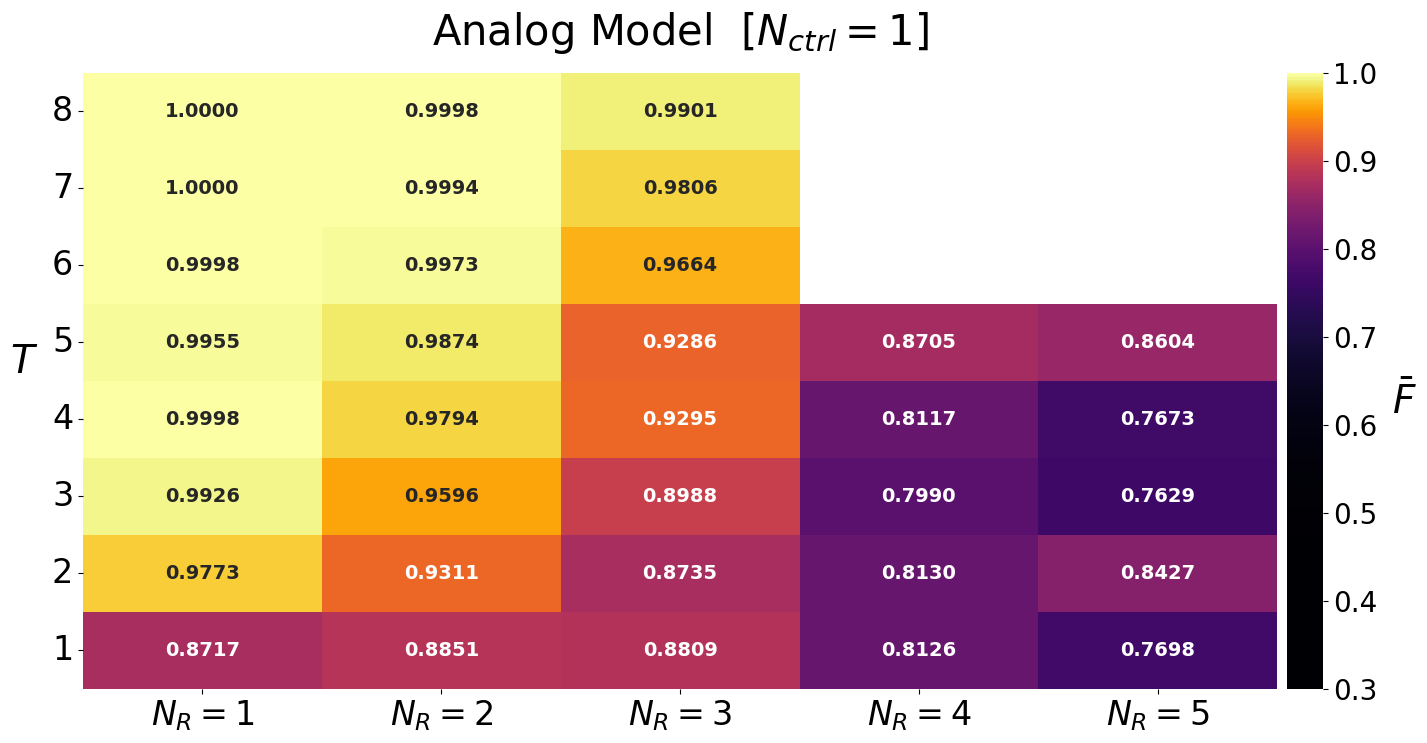

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_14494/2207344524.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)


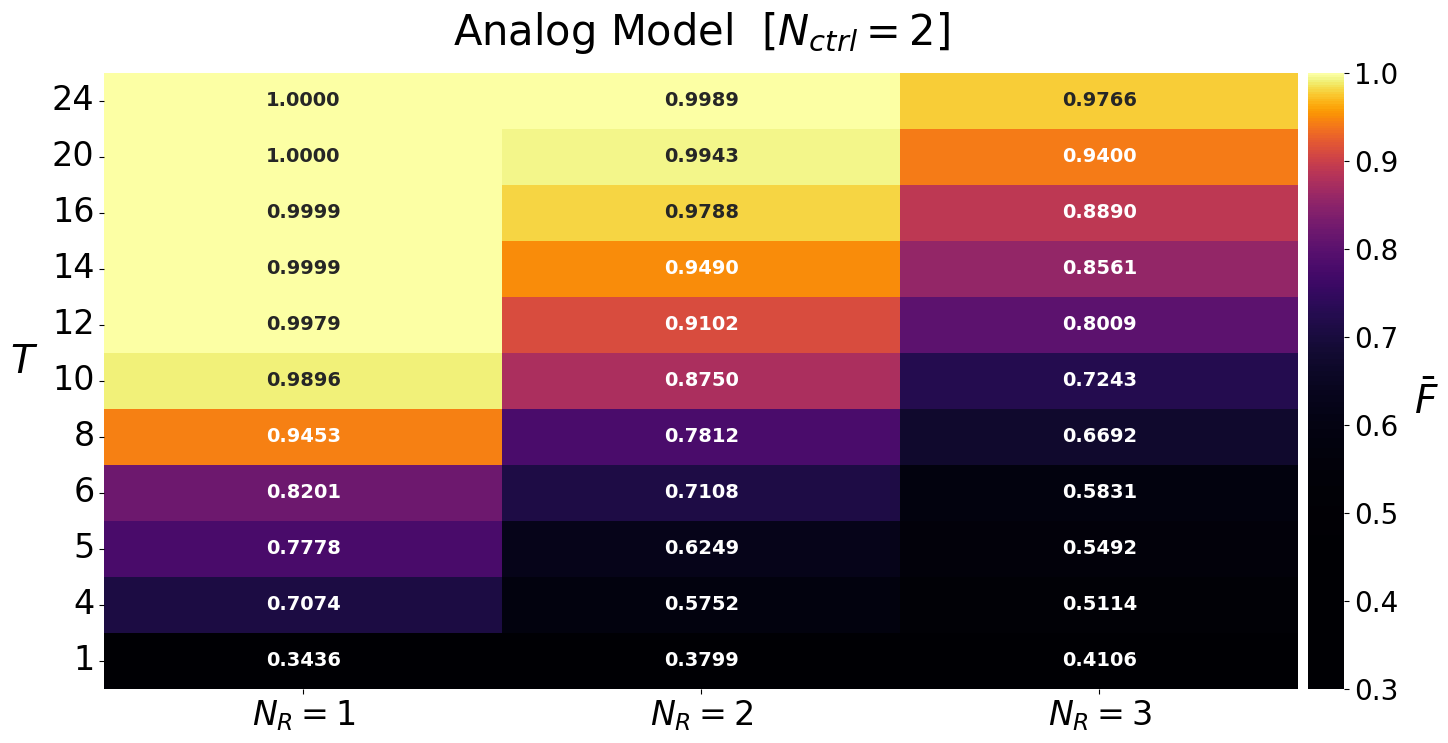

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_14494/2207344524.py:32: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)


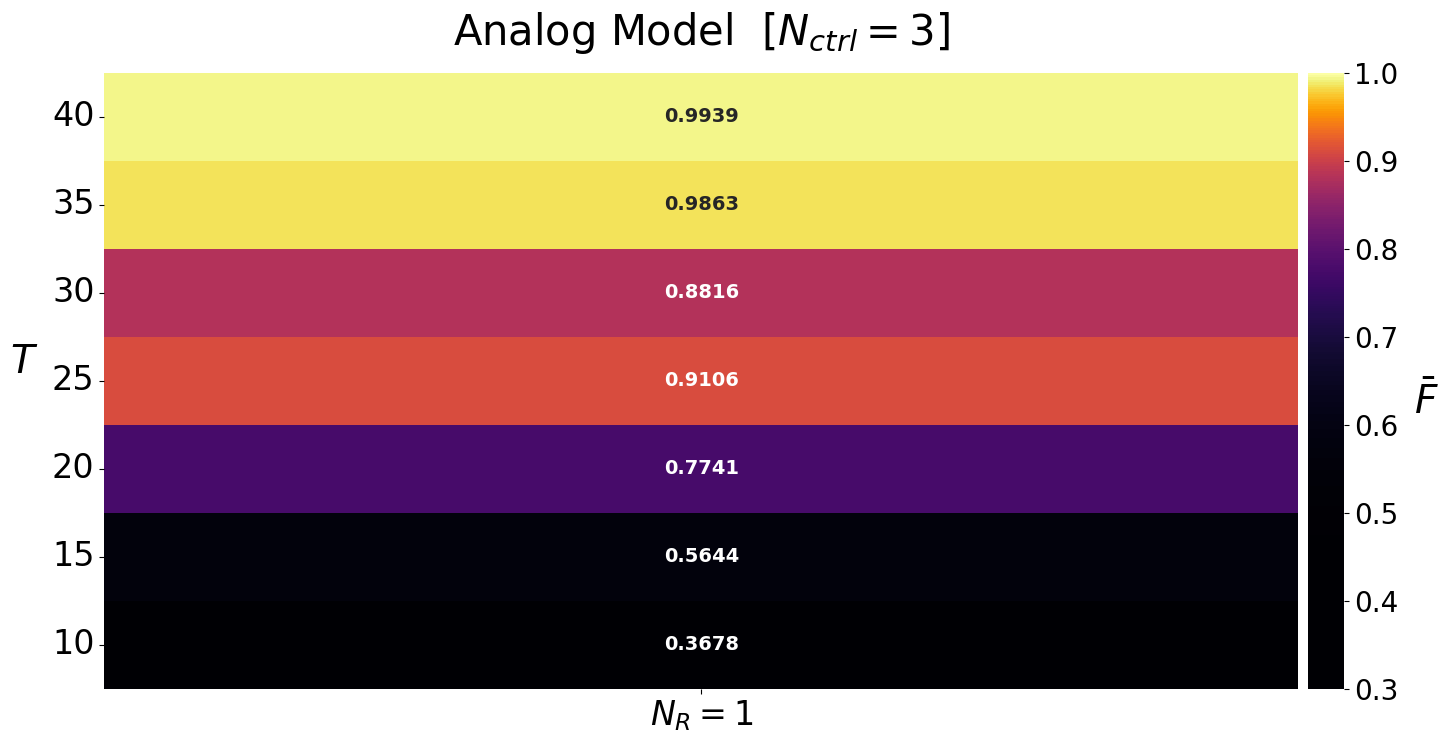

In [79]:
# analog_data_df = all_data_df[all_data_df[''] == 18]


from mpl_toolkits.axes_grid1 import make_axes_locatable
width = 0.6# Width of the bars in the bar plot
n_colors = 256  # Number of colors in the colormap for visual differentiation
n_groups = len(reservoir_counts)  # Number of groups, now based on bath counts
base_colormap = plt.cm.inferno  # Base colormap for visual appeal

for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 4,5, 6, 8, 10, 12, 14, 16, 20, 24]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5,6,7,8]
    elif N_ctrl == 3:
        trots = np.arange(1,50,1)

    # Filter data for the current N_ctrl and specific Trotter steps
    data_df = all_data_df[(all_data_df['N_C'] == N_ctrl) & (all_data_df['Trotter_Step'].isin(trots))]

    # Compute average fidelity and standard deviation for each Trotter step and Reservoir Count
    averaged_data = data_df.groupby(['Trotter_Step', 'Reservoir Count']).agg(
        Average_Fidelity=('Avg_Fidelity', 'mean'),
        Std_Dev=('Avg_Fidelity', 'std')
    ).reset_index()

    # Pivot the data for the heatmap
    pivot_avg = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="Average_Fidelity")
    pivot_std = averaged_data.pivot(index="Trotter_Step", columns="Reservoir Count", values="Std_Dev")

    # Create annotation matrix for Average Fidelity heatmap
    annotation_matrix_avg = pivot_avg.applymap("{:.4f}".format)

    # Define the custom colormap
    values = np.linspace(0, 1, n_colors)**4
    colors = base_colormap(values)
    custom_colormap = mcolors.LinearSegmentedColormap.from_list('custom_inferno', colors, N=n_colors)

    # Create the figure and axis for the heatmap
    fig, axs = plt.subplots(1, figsize=(16, 8))
    heatmap_ax_avg = axs

    # Create a divider for the existing axes instance
    divider = make_axes_locatable(heatmap_ax_avg)
    cax = divider.append_axes("right", size="3%", pad=0.1)

    # Plot the average fidelity heatmap with annotations
    sns.heatmap(
        pivot_avg, annot=annotation_matrix_avg, fmt="s", cmap=custom_colormap, 
        ax=heatmap_ax_avg, cbar_ax=cax, cbar_kws={'label': 'Fidelity'}, 
        annot_kws={"weight": "bold", "size": 14}, vmin=0.3, vmax=1.00
    )

    # Adjust the color bar
    cbar = heatmap_ax_avg.collections[0].colorbar
    cbar.ax.tick_params(labelsize=20)
    cbar.set_label(r'$\bar{F}$', rotation=0, labelpad=20, fontsize=28, weight='bold')

    # Customize the plot appearance
    heatmap_ax_avg.invert_yaxis()
    heatmap_ax_avg.set_title(f'Analog Model  [$N_{{ctrl}} = {N_ctrl}$]', fontsize=30, pad=20)
    heatmap_ax_avg.set_ylabel("$T$", labelpad=20, fontsize=28, rotation=0)
    heatmap_ax_avg.set_xticklabels([f'$N_R = {int(rc)}$' for rc in pivot_avg.columns], fontweight='bold', fontsize=24, rotation=0)
    heatmap_ax_avg.set_yticklabels([int(ts) for ts in pivot_avg.index], fontsize=24, rotation=0)
    heatmap_ax_avg.set_xlabel('')

    plt.show()
    

final_cost: 0.9985. avg fidelity 1: 0.998657 +- 0.000511
200 (6, 5, 2)
lr: 0.01954, train state 0:  [0.07868556-0.72345376j 0.14301689+0.6707976j ]

final_cost: 0.9988. avg fidelity 3: 0.998683 +- 0.001093
101 (8, 0, 2)
0.1777236

final_cost: 0.5574. avg fidelity 3: 0.578566 +- 0.187664
100 (6, 8, 2)
lr: 0.01954, train state 0:  [ 0.03621395-0.88394874j -0.42234626-0.19734955j]
0.1777236


y ticks: [-7. -6. -5. -4. -3. -2. -1.  0.  1.]


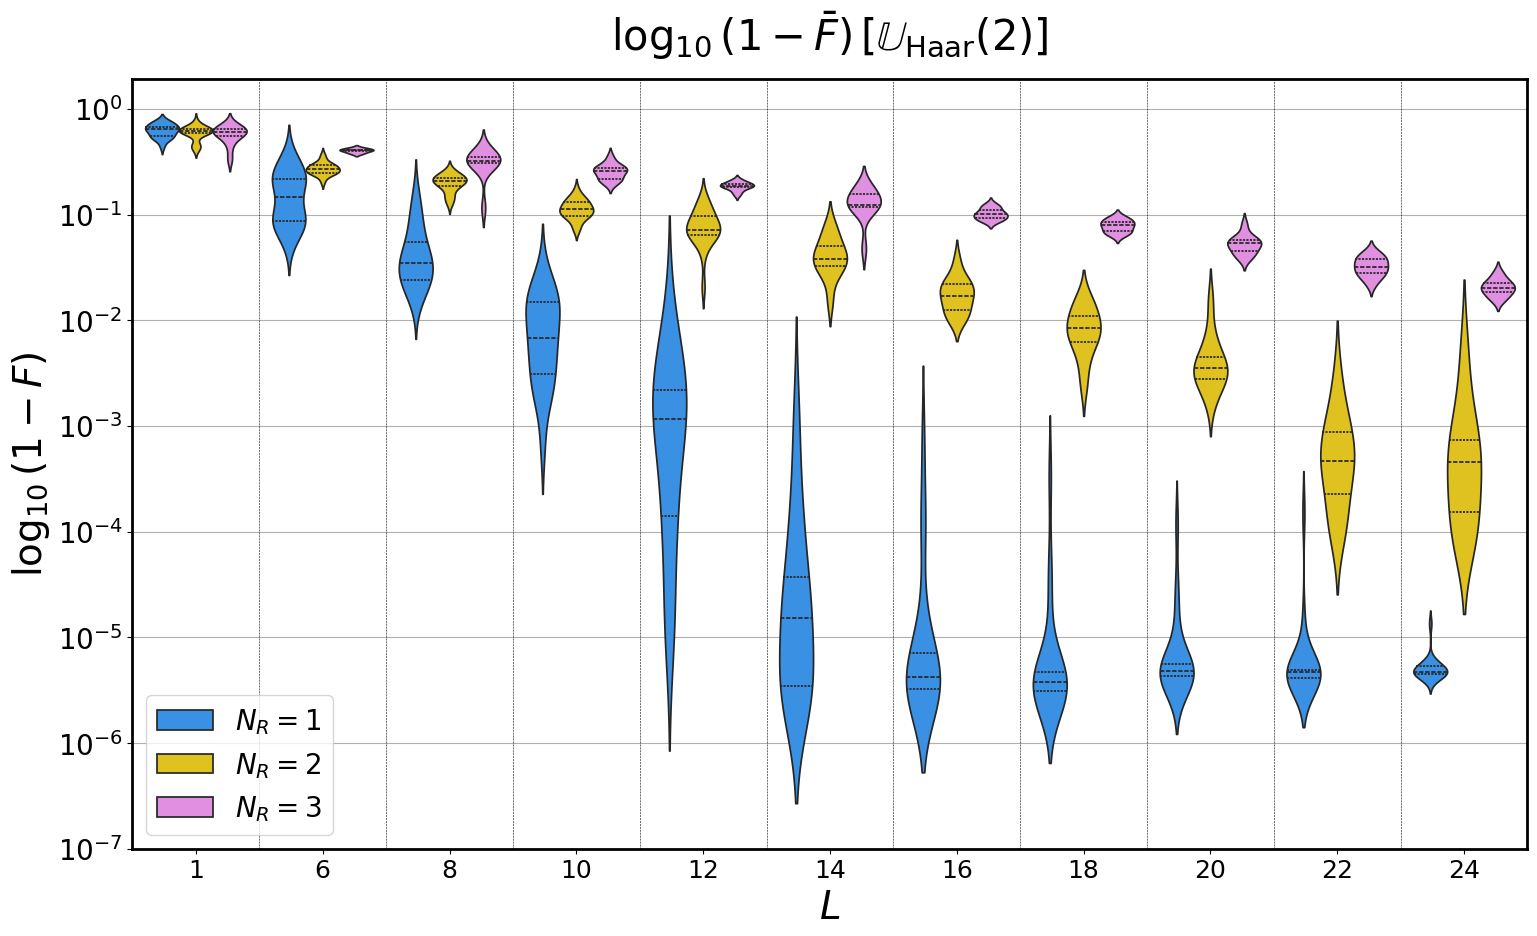

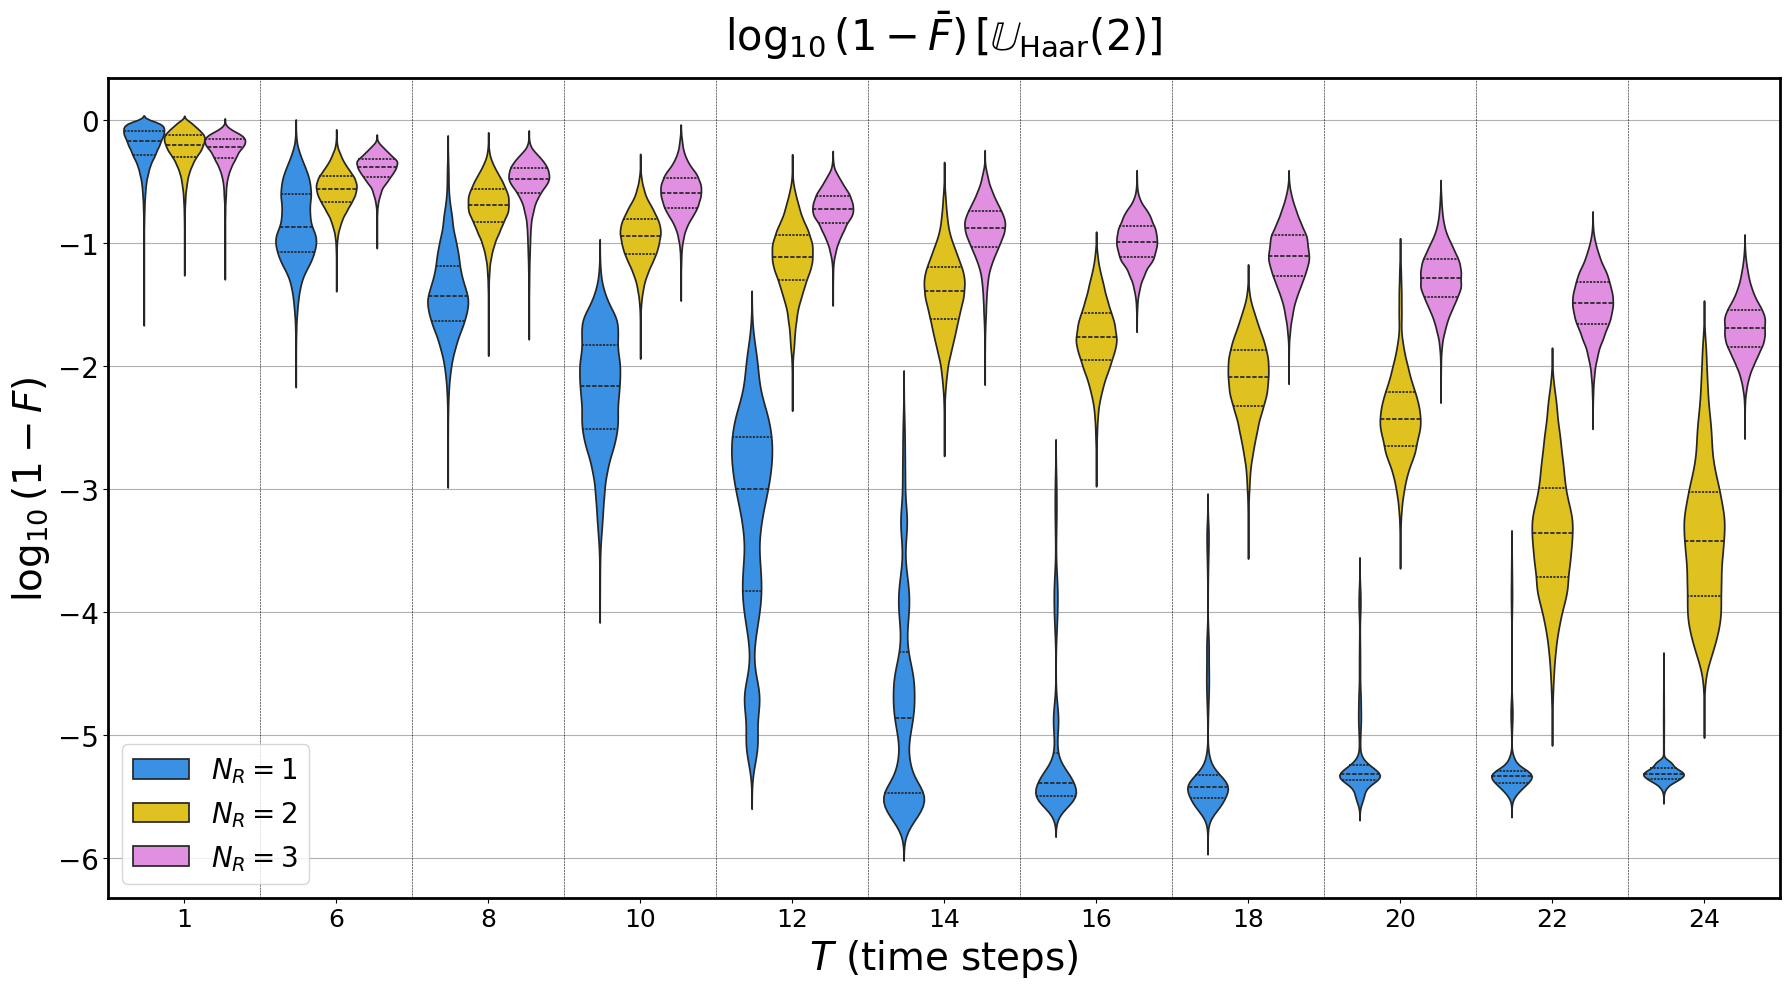

In [80]:

N_ctrl = 2
# data_df = all_data_df[(all_data_df['Trotter_Step'] < 6) & (all_data_df['N_C'] == N_ctrl)]
resies = [1,2,3]
if N_ctrl == 2:
    trots = [1, 6, 8, 10, 12, 14, 16, 18,20, 22,24]
elif N_ctrl == 1:
    trots = [1, 2, 3, 4, 5,6,7,8,9,10]
    trots = [ 2, 3, 4]
    resies=[1]
data_df = all_data_df[
    (all_data_df['N_C'] == N_ctrl) & 
    (all_data_df['Reservoir Count'].isin(resies)) &
     (all_data_df['Trotter_Step'].isin(trots))
]

custom_palette = {1: 'dodgerblue', 2: 'gold', 3:'violet', 4: 'green'}

fig, axs = plt.subplots(1, figsize=(18, 10)) 
# Set the linewidth of the outside border (spines)
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels
# First violin plot for Average Error (log10(1 - avg_fidelity))
sns.violinplot(x='Trotter_Step', y='Avg Error', hue='Reservoir Count', data=data_df, 
               ax=axs, palette=custom_palette, density_norm='width', inner="quartile")

axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
axs.set_xlabel('$L$', fontsize=28)
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)  # Set legend in upper right
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick,max_tick+1,1)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Set tick parameters
axs.tick_params(axis='y', labelsize=20) 
axs.tick_params(axis='x', labelsize=18) 
unique_x_ticks = sorted(data_df['Trotter_Step'].unique()) 
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)
""" 

Second violin plot for Error_Test_Results (log10(1 - Test Results)) 

"""
# Explode test results into separate rows to plot each error individually
test_results_df = data_df.explode('Error_Test_Results')

fig, axs = plt.subplots(1, figsize=(18, 10)) 
for spine in axs.spines.values():
    spine.set_linewidth(2)  # Set linewidth to 2 pixels
sns.violinplot(x='Trotter_Step',  y='Error_Test_Results', hue='Reservoir Count', data=test_results_df, ax=axs,
               palette=custom_palette, density_norm='width', inner='quartile', saturation=0.75)
axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)

axs.set_xlabel('$T$ (time steps)', fontsize=28)
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)

axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)
handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)  # Set legend in upper right
y_ticks = axs.get_yticks()
print(f"y ticks: {y_ticks}")
# whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
# min_tick = min(whole_y_ticks)
# max_tick = max(whole_y_ticks)
# whole_y_ticks = np.arange(min_tick-3,max_tick+1,1)
# # print(whole_y_ticks)
# # axs.set_yticks(whole_y_ticks)
# axs.set_yticks(whole_y_ticks)
# axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Set tick parameters
axs.tick_params(axis='y', labelsize=20) 
axs.tick_params(axis='x', labelsize=18) 
unique_x_ticks = sorted(data_df['Trotter_Step'].unique()) 
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)
# Add vertical lines between groups
# unique_trotter_steps = test_results_df['Trotter_Step'].unique()
# positions = range(1, len(unique_trotter_steps), 1)
# for pos in positions:
#     axs.axvline(x=pos - 0.5, color='black', linewidth=0.4)
# Adjust the layout and show the plots
plt.tight_layout()
plt.show()


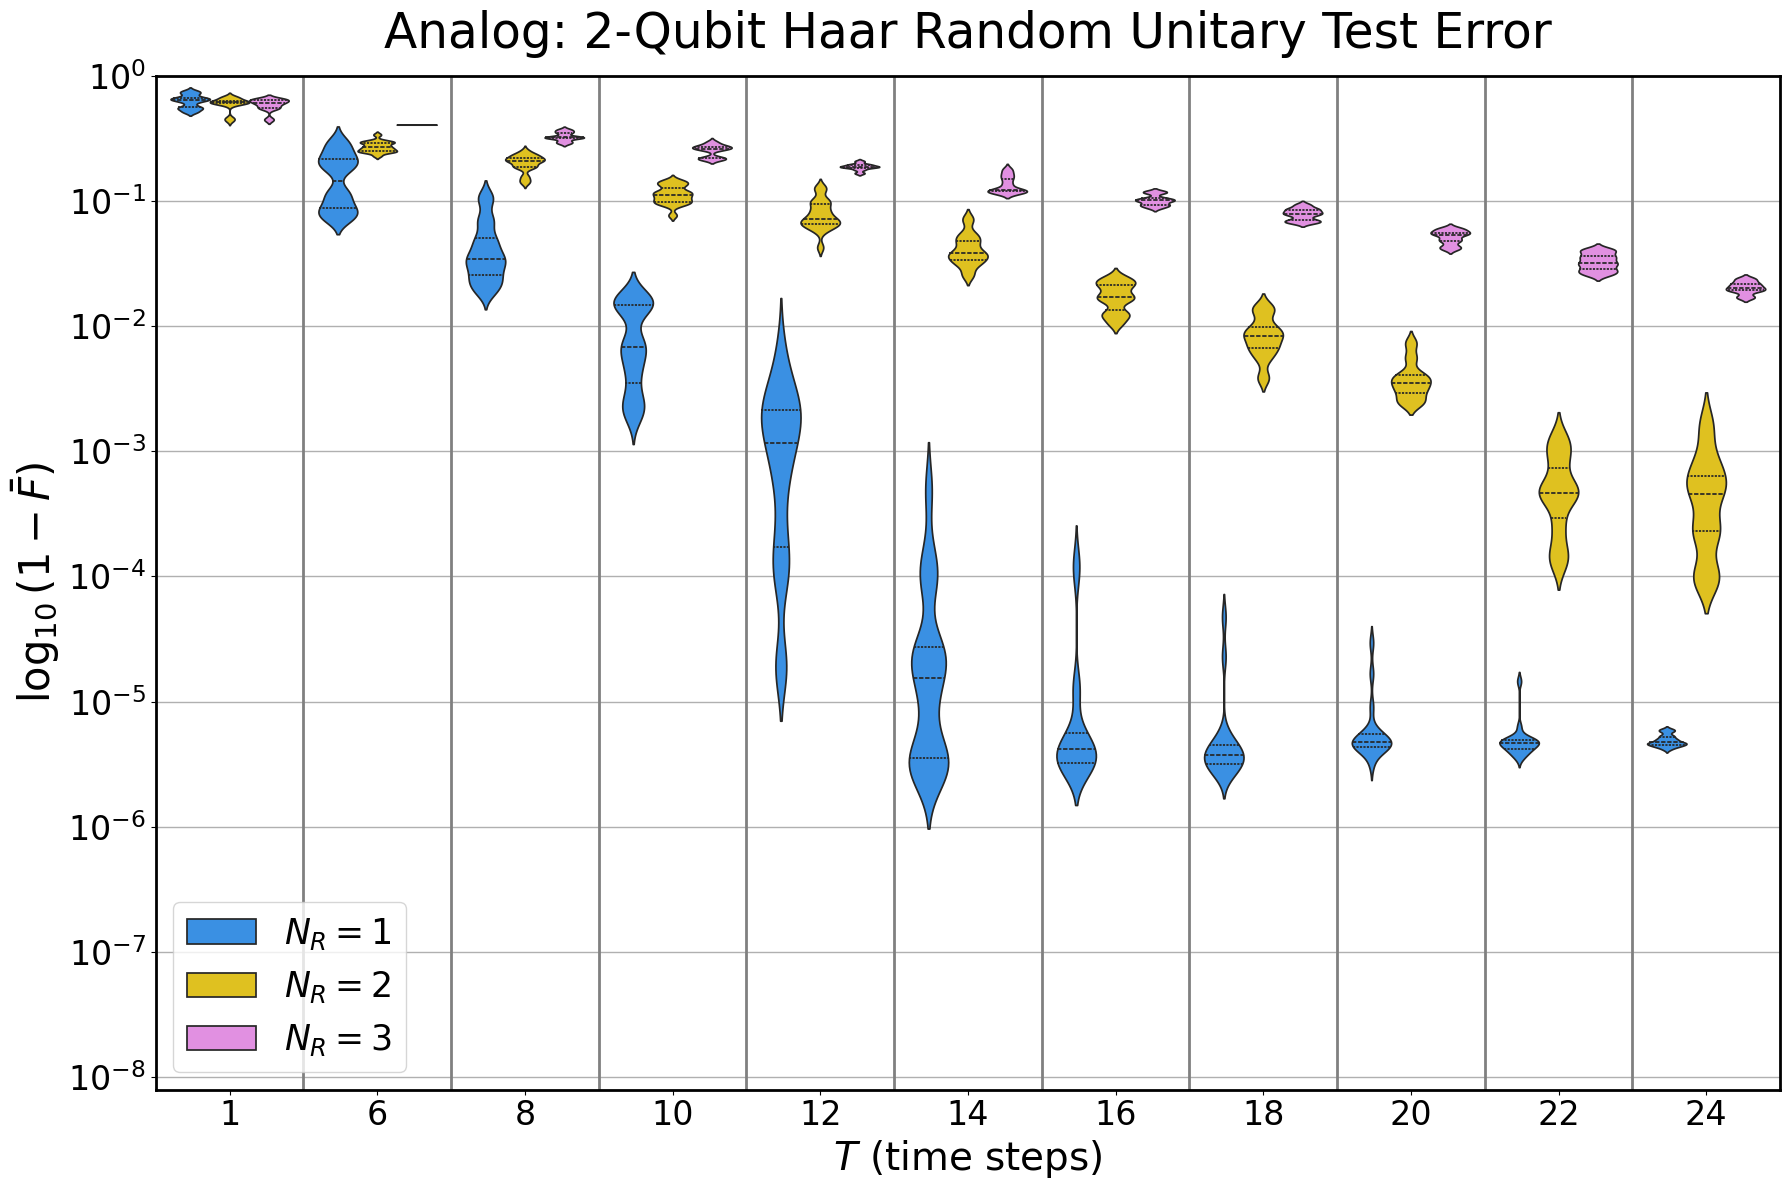

In [83]:
# Calculate IQR for 'Avg Error' grouped by Trotter_Step and Reservoir Count
# Calculate IQR for 'Avg Error'
avg_error_iqr_filtered_data = []
grouped_avg_error = data_df.groupby(['Trotter_Step', 'Reservoir Count'])
for (trotter_step, reservoir_count), group in grouped_avg_error:
    q1 = np.percentile(group['Avg Error'], 1)
    q3 = np.percentile(group['Avg Error'], 95)

    # Filter data within IQR for 'Avg Error'
    filtered_group = group[(group['Avg Error'] >= q1) & (group['Avg Error'] <= q3)]
    avg_error_iqr_filtered_data.append(filtered_group)

avg_error_iqr_filtered_data_df = pd.concat(avg_error_iqr_filtered_data)



# Plot the first violin plot
fig, axs = plt.subplots(1, figsize=(18, 12))
for spine in axs.spines.values():
    spine.set_linewidth(2)

sns.violinplot(
    x='Trotter_Step',
    y='Avg Error',
    hue='Reservoir Count',
    data=avg_error_iqr_filtered_data_df,
    ax=axs,
    palette=custom_palette,
    density_norm='width',
    common_norm=True,
    inner="quartile",
    bw_adjust=0.5
)

axs.set_title(f"Analog: {N_ctrl}-Qubit Haar Random Unitary Test Error", fontsize=35, pad=20)

# axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
axs.set_xlabel('$T$ (time steps)', fontsize=28)
axs.set_ylabel(f'$\log_{{10}}(1 - \\bar{{F}})$', fontsize=30)
axs.grid(True, which='major', axis='y', linewidth=1)  # Set the desired linewidth

axs.set_axisbelow(True)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

# Y-tick adjustments
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick-1, max_tick + 1, 1)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

axs.tick_params(axis='y', labelsize=24)
axs.tick_params(axis='x', labelsize=24)
axs.set_ylim(-8.1,0)

# Add vertical lines
unique_x_ticks = sorted(avg_error_iqr_filtered_data_df['Trotter_Step'].unique())
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='gray', linestyle='-', linewidth=2)
# fig.patch.set_linewidth(2)
# fig.patch.set_edgecolor('black')
plt.tight_layout()
plt.show()


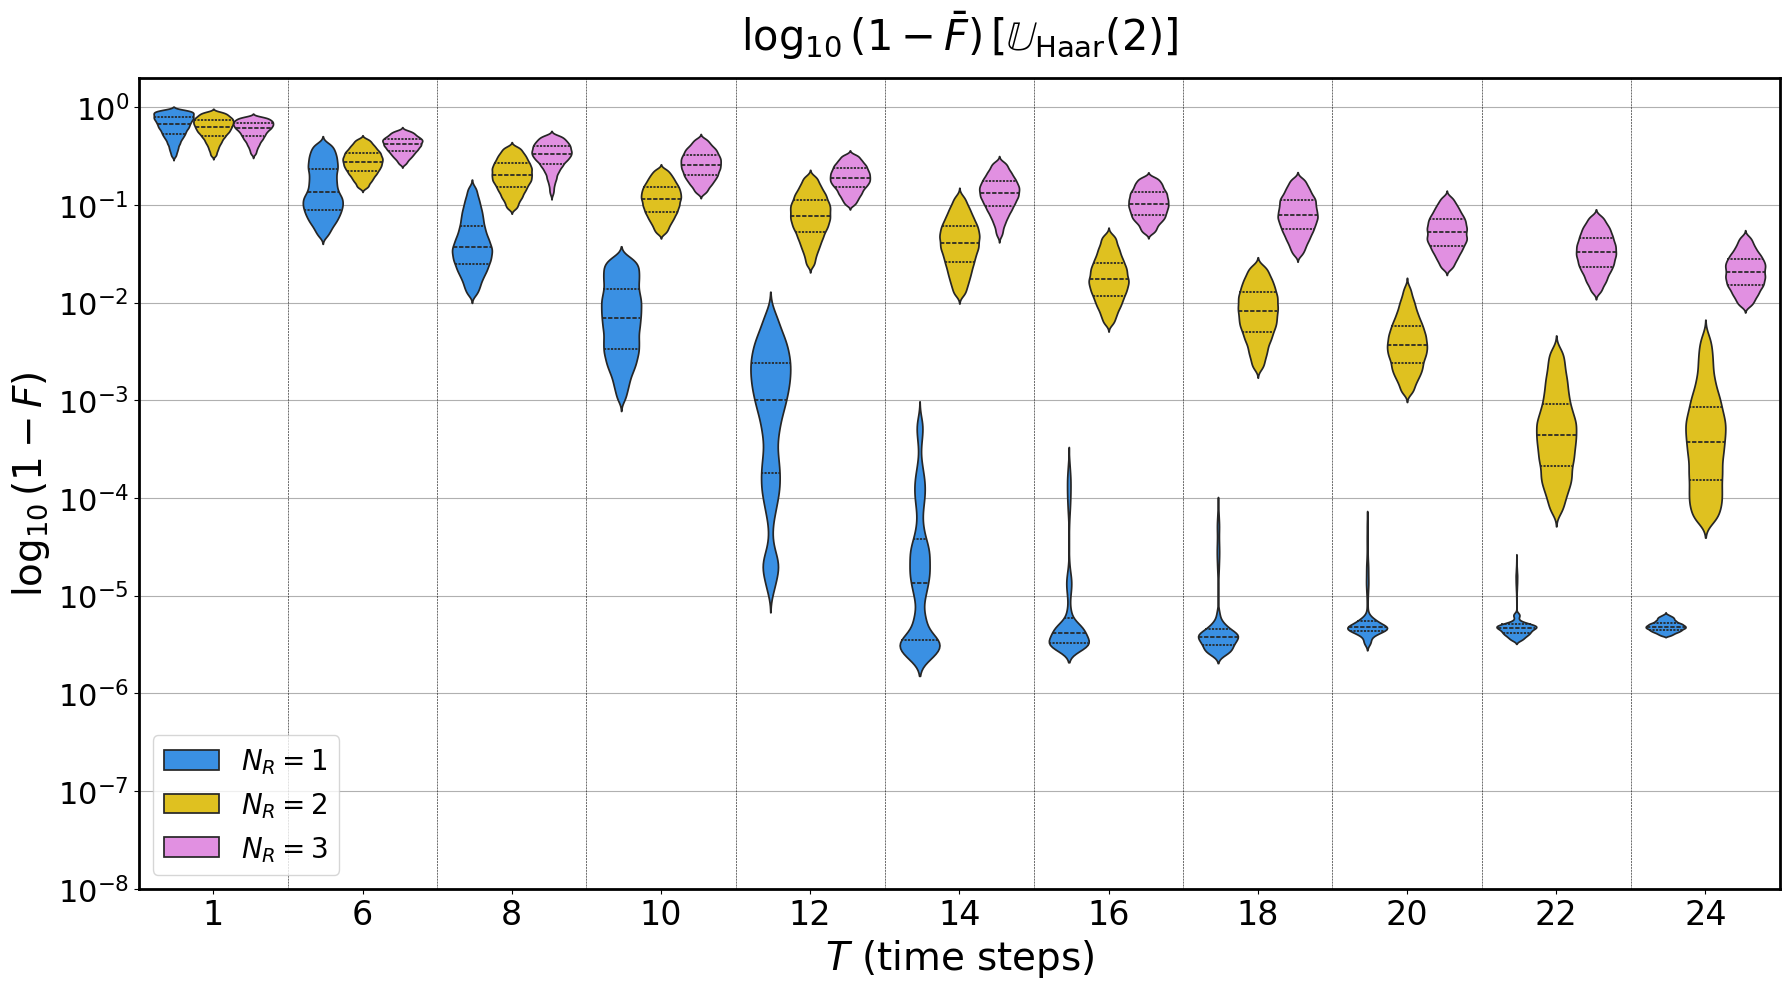

In [84]:
# Calculate IQR for 'Error_Test_Results' grouped by Trotter_Step and Reservoir Count
iqr_filtered_data = []
grouped = test_results_df.groupby(['Trotter_Step', 'Reservoir Count'])
for (trotter_step, reservoir_count), group in grouped:
    q1 = np.percentile(group['Error_Test_Results'], 5)
    q3 = np.percentile(group['Error_Test_Results'], 95)

    # Filter data to include only points within the IQR
    filtered_group = group[
        (group['Error_Test_Results'] >= q1) & (group['Error_Test_Results'] <= q3)
    ]
    iqr_filtered_data.append(filtered_group)

# Concatenate the filtered data
iqr_filtered_data_df = pd.concat(iqr_filtered_data)

# Plot the second violin plot
fig, axs = plt.subplots(1, figsize=(18, 10))
for spine in axs.spines.values():
    spine.set_linewidth(2)

sns.violinplot(
    x='Trotter_Step',
    y='Error_Test_Results',
    hue='Reservoir Count',
    data=iqr_filtered_data_df,
    ax=axs,
    palette=custom_palette,
    density_norm='width',
    inner='quartile',
    # saturation=0.75,
    common_norm=True
)

axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
axs.set_xlabel('$T$ (time steps)', fontsize=28)
axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)
axs.yaxis.grid(True)
axs.xaxis.grid(False)
axs.set_axisbelow(True)

handles, labels = axs.get_legend_handles_labels()
axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)

# Y-tick adjustments
y_ticks = axs.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick-1, max_tick + 1, 1)
axs.set_yticks(whole_y_ticks)
axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

axs.tick_params(axis='y', labelsize=22)
axs.tick_params(axis='x', labelsize=24)

# Add vertical lines
unique_x_ticks = sorted(iqr_filtered_data_df['Trotter_Step'].unique())
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    axs.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

plt.tight_layout()
plt.show()


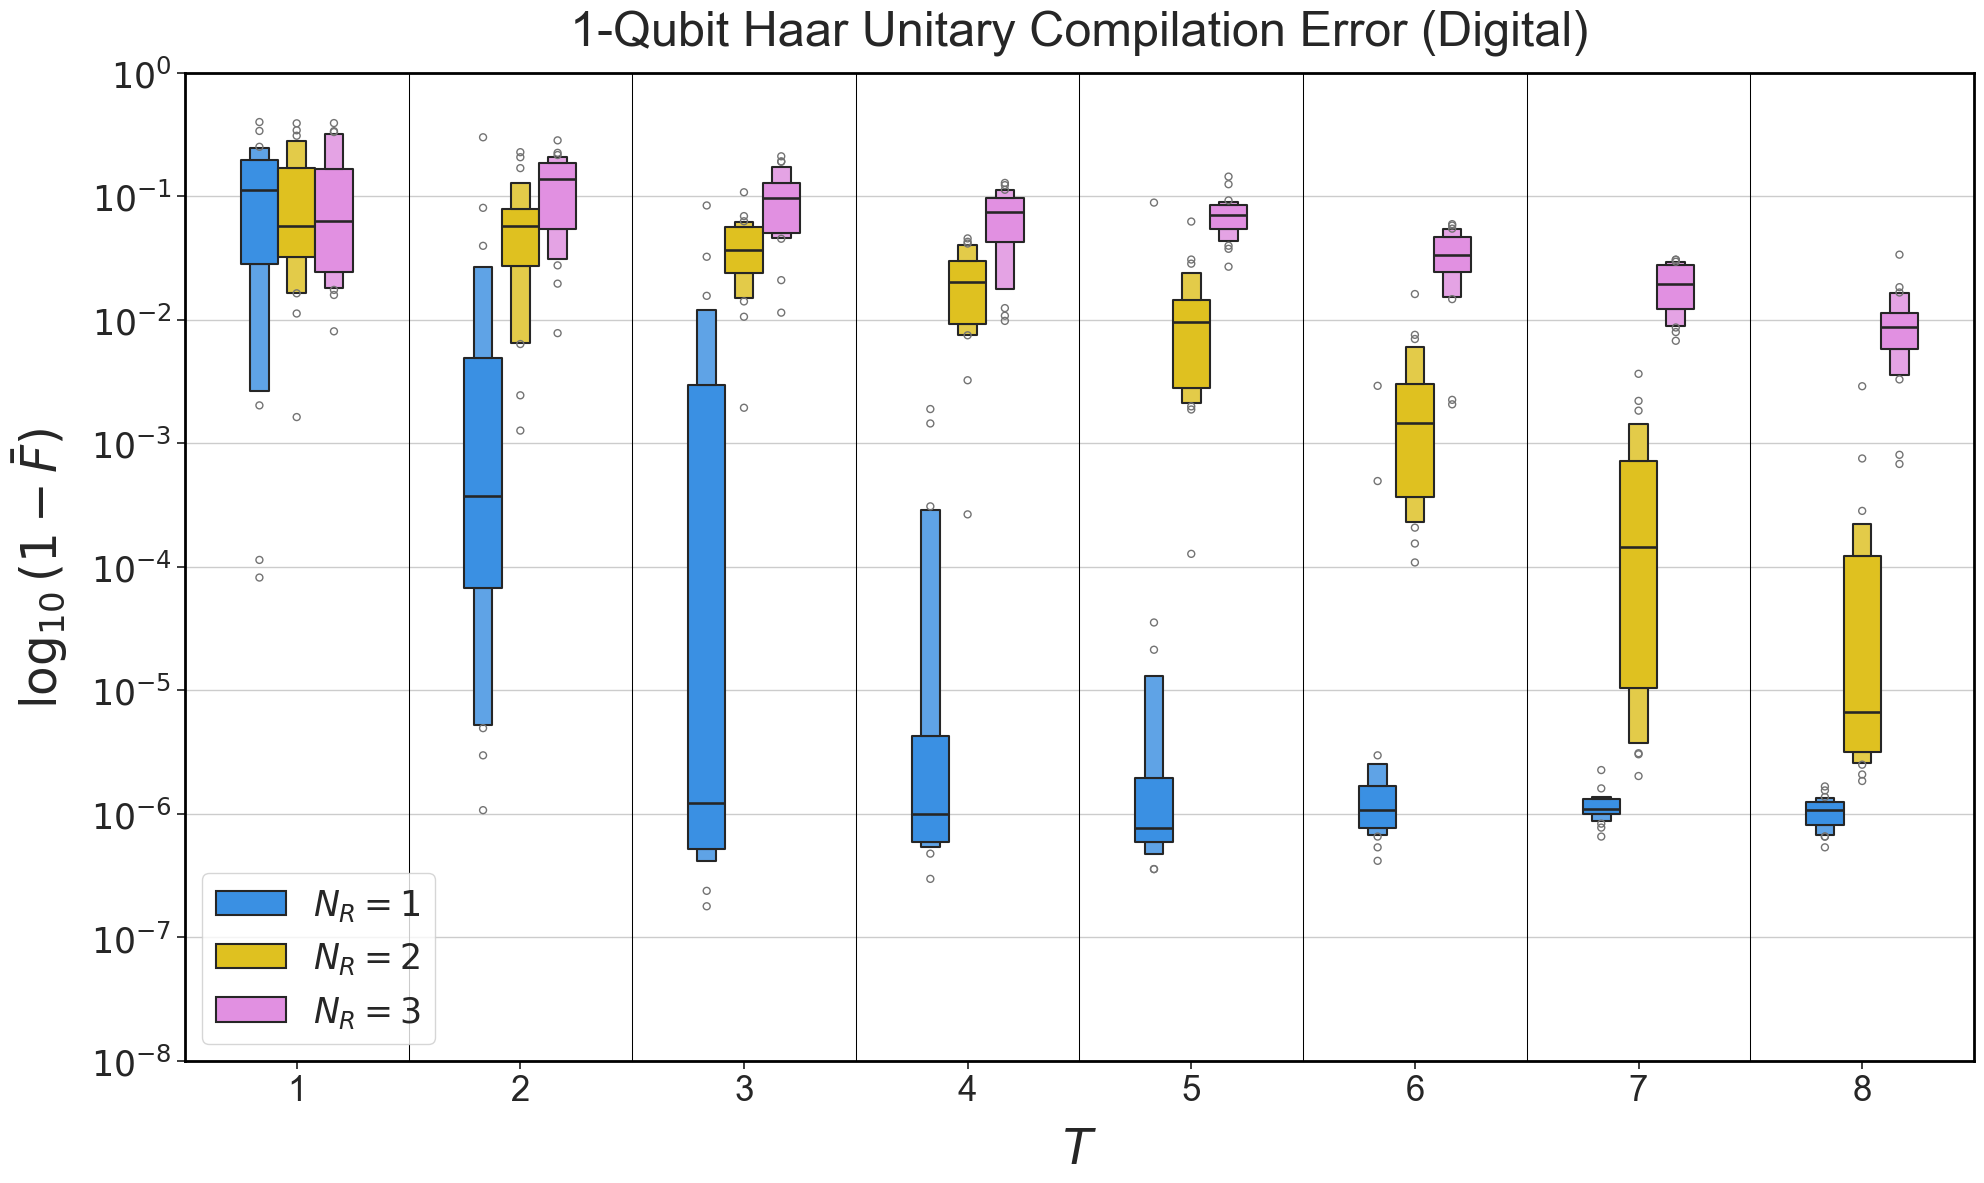

In [75]:
resies=[1,2,3]
N_ctrls = [1]
for N_ctrl in N_ctrls:
    if N_ctrl == 2:
        trots = [1, 6, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 24, 25, 26, 27, 28]
    elif N_ctrl == 1:
        trots = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

    # Filter the DataFrame for specific N_C (control qubits)
    data_df = all_data_df[all_data_df['N_C'] == N_ctrl]
    data_df = data_df[data_df['Trotter_Step'].isin(trots)]
    data_df = data_df[data_df['Reservoir Count'].isin(resies)]

    # Explode test results into separate rows to plot each error individually
    test_results_df = data_df.explode('Avg Error')

    # Find the common Trotter steps across all reservoir counts
    grouped_trotter_steps = test_results_df.groupby(['Trotter_Step', 'Reservoir Count']).size().unstack(fill_value=0)
    valid_trotter_steps = grouped_trotter_steps[(grouped_trotter_steps > 0).all(axis=1)].index

    # Filter the DataFrame to only include those Trotter steps
    test_results_df = test_results_df[test_results_df['Trotter_Step'].isin(valid_trotter_steps)]

    # Plot for each control qubit
    fig, axs = plt.subplots(1, figsize=(20, 12))

    # Set the linewidth of the outside border (spines)
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels

    # Boxenplot for Error_Test_Results (log10(1 - Test Results))
    sns.boxenplot(
        x='Trotter_Step',
        y='Avg Error',
        hue='Reservoir Count',
        data=test_results_df,
        ax=axs,
        palette=custom_palette,
        k_depth='trustworthy',
        linewidth=1.5,
        # gap=0.1,
        width_method="linear",
        width=.5
    )

    # Set titles and labels with padding
    axs.set_title(f"{N_ctrl}-Qubit Haar Unitary Compilation Error (Digital)", fontsize=35, pad=20)
    axs.set_xlabel('$T$', fontsize=35, labelpad=15)  # X-axis label with padding
    axs.set_ylabel(r'$\log_{10}\left(1 - \bar{F}\right)$', fontsize=35, labelpad=15)  # Y-axis label with padding

    # Add grid lines
    axs.yaxis.grid(True)
    axs.xaxis.grid(False)
    axs.set_axisbelow(True)

    # Customize the legend
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=25)

    # Set the global Y-limits
    # axs.set_ylim(global_min_y, global_max_y)

    # Set Y-ticks and labels
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    min_tick = min(whole_y_ticks)
    max_tick = max(whole_y_ticks)
    whole_y_ticks = np.arange(min_tick, max_tick + 1, 1)
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    # Set tick parameters
    axs.tick_params(axis='y', labelsize=25)
    axs.tick_params(axis='x', labelsize=25)

    # Add vertical lines to separate groups
    unique_trotter_steps = test_results_df['Trotter_Step'].unique()
    positions = range(1, len(unique_trotter_steps), 1)
    for pos in positions:
        axs.axvline(x=pos - 0.5, color='black', linewidth=0.75)

    # Prevent clipping of y-axis ticks/labels
    plt.tight_layout()
    plt.show()



In [54]:
# filt_df = data_df[data_df['Reservoir Count'] == 2]
filt_df = data_df[(data_df['Trotter_Step'] == 3) & (data_df['Reservoir Count'] == 2)]

filt_df.head()

,N_C,Trotter Step,Gate,Reservoir Count,Avg_Fidelity,Error Test Results,Avg Error,Costs,Test Results,N_params,run
12,1,3,U1_0,2,0.975847,"[-1.4725008384903508, -1.429438575146679, -1.4...",-1.617022,"[0.5698666572570801, 0.5622707605361938, 0.556...","[0.9663101434707642, 0.9627984166145325, 0.965...",12,data_run_0
27,1,3,U1_1,2,0.999567,"[-3.0394044379318923, -3.432328206437295, -3.5...",-3.363903,"[0.5970616340637207, 0.5805068612098694, 0.562...","[0.9990867376327515, 0.9996304512023926, 0.999...",12,data_run_0
42,1,3,U1_10,2,0.989919,"[-2.4308038493512933, -2.4551579600874898, -2....",-1.996494,"[0.5531677007675171, 0.5268149971961975, 0.504...","[0.9962915182113647, 0.9964937567710876, 0.994...",12,data_run_0
57,1,3,U1_11,2,0.963833,"[-1.5351828479322844, -1.5005899082253142, -1....",-1.441684,"[0.5045968294143677, 0.48835253715515137, 0.47...","[0.9708380103111267, 0.968420147895813, 0.9780...",12,data_run_0
72,1,3,U1_12,2,0.979901,"[-2.6049693572432493, -1.4304989214049881, -1....",-1.696832,"[0.3473884165287018, 0.31353890895843506, 0.28...","[0.9975166916847229, 0.9628891348838806, 0.975...",12,data_run_0


In [57]:
# Group by 'Gate' and calculate the average fidelity for each gate
avg_fidelity_per_gate = filt_df.groupby('Gate')['Avg_Fidelity'].mean()
retest = []
# Print the result
for gate, avg_fidelity in avg_fidelity_per_gate.items():
    num = int(gate.split('_')[-1])
    # if avg_fidelity < 0.95:
    if num in [6,7,8]:
        # num = int(gate.split('_')[-1])
        # retest.append(num)
        print(f"Gate: {gate}, Average Fidelity: {avg_fidelity}")
# retest

Gate: U1_6, Average Fidelity: 0.9565520286560059
Gate: U1_7, Average Fidelity: 0.953138530254364
Gate: U1_8, Average Fidelity: 0.9739714860916138


In [55]:
def get_n_params(type_model, Nr, steps, Nc):
    # print(type_model)
    if type_model:  # Analog model
        return steps * Nr * Nc + steps +3
    else:  # Digital model
        return steps * Nr * Nc+3
    
def get_df(data_i, trots, type_model, Nc):
    
    infidelity_data = {}
    infidelity_data_averaged = {}
    for gate, gate_data in data_i.items():
        for reservoir_count, trotter_data in gate_data.items():

            for trotter_step, results in trotter_data.items():
                #if not trotter_step in trots:
                #    continue
                infidelity_data_averaged.setdefault(trotter_step, {}).setdefault(reservoir_count, [])

                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, [])
                print(results)
                test_results = results['test_results']
                test_results = np.clip(test_results, 0, 1)
                average_fidelity = results['fidelity']
                average_infidelity = 1 - average_fidelity
                # Check if there are invalid infidelities
                # invalid_infidelities = np.array(test_results)[(np.array(test_results) < 0) | (np.array(test_results) > 1)]
                # if np.any(np.array(test_results) < 0) or np.any(np.array(test_results) > 1):
                #     print(f"Invalid infidelities found in {trotter_step} for {reservoir_count}")
                #     print(f"invalid_infidelities: {invalid_infidelities}")
                #     continue
                infidelity_res = 1 - np.array(test_results)
                
                
                infidelity_data.setdefault(trotter_step, {}).setdefault(reservoir_count, []).extend(infidelity_res)
                infidelity_data_averaged[trotter_step][reservoir_count].append(average_infidelity)
     
    all_trotter_steps = sorted(infidelity_data.keys())



    violin_plot_data_all = []
    for trotter_step, res_data in infidelity_data.items():
        for reservoir_count, infidelities in res_data.items():
            n_param =  get_n_params(type_model,reservoir_count,trotter_step,Nc)
            log_infidelities = [np.log10(infidelity) if infidelity > 0 else -np.inf for infidelity in infidelities]  # Calculate log
            violin_plot_data_all.extend([(trotter_step, reservoir_count, log_inf, n_param) for log_inf in log_infidelities])

    df_violin_all = pd.DataFrame(violin_plot_data_all, columns=['Trotter_Step', 'Reservoir Count', 'Log(Infidelity)','n_param'])

    # Prepare data for violin plot with log(infidelity)
    violin_plot_data_avg = []
    for trotter_step, res_data in infidelity_data_averaged.items():
        for reservoir_count, infidelities in res_data.items():
            n_param =  get_n_params(type_model,reservoir_count,trotter_step,Nc)
            for infidelity in infidelities:
                log_infidelity = np.log10(infidelity) if infidelity > 0 else -np.inf
                violin_plot_data_avg.append((trotter_step, reservoir_count, log_infidelity, n_param))
                
    df_violin_avg = pd.DataFrame(violin_plot_data_avg, columns=['Trotter_Step', 'Reservoir Count', 'Log(Infidelity)', 'n_param'])
    return df_violin_all,df_violin_avg
def find_matching_params_trotter_steps(N_ctrl, N_reserv, Nc):
    if N_ctrl == 3:
        trots = np.arange(1,60,1) 
    else:
        trots = np.arange(1,60,1)

    # Dictionary to store Trotter steps by parameter count for digital and analog models
    digital_param_steps = {}
    analog_param_steps = {}

    for trotter_step in trots:
        # Get number of parameters for digital (type_model = 0) and analog (type_model = 1) models
        n_params_digital = get_n_params(0, N_reserv, trotter_step, Nc)
        n_params_analog = get_n_params(1, N_reserv, trotter_step, Nc)

        # Store Trotter steps grouped by parameter counts
        if n_params_digital not in digital_param_steps:
            digital_param_steps[n_params_digital] = []
        digital_param_steps[n_params_digital].append(trotter_step)

        if n_params_analog not in analog_param_steps:
            analog_param_steps[n_params_analog] = []
        analog_param_steps[n_params_analog].append(trotter_step)

    # Separate lists for matching Trotter steps
    matching_digital_steps = []
    matching_analog_steps = []

    # Find common parameter counts between digital and analog models
    for param_count in digital_param_steps:
        if param_count in analog_param_steps:
            # print(param_count)
            matching_digital_steps.extend(digital_param_steps[param_count])
            matching_analog_steps.extend(analog_param_steps[param_count])

    return matching_digital_steps, matching_analog_steps


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_48584/3407532870.py:108: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(x='Trotter_Step',  y='Error_Test_Results', hue='Reservoir Count', data=test_results_df,


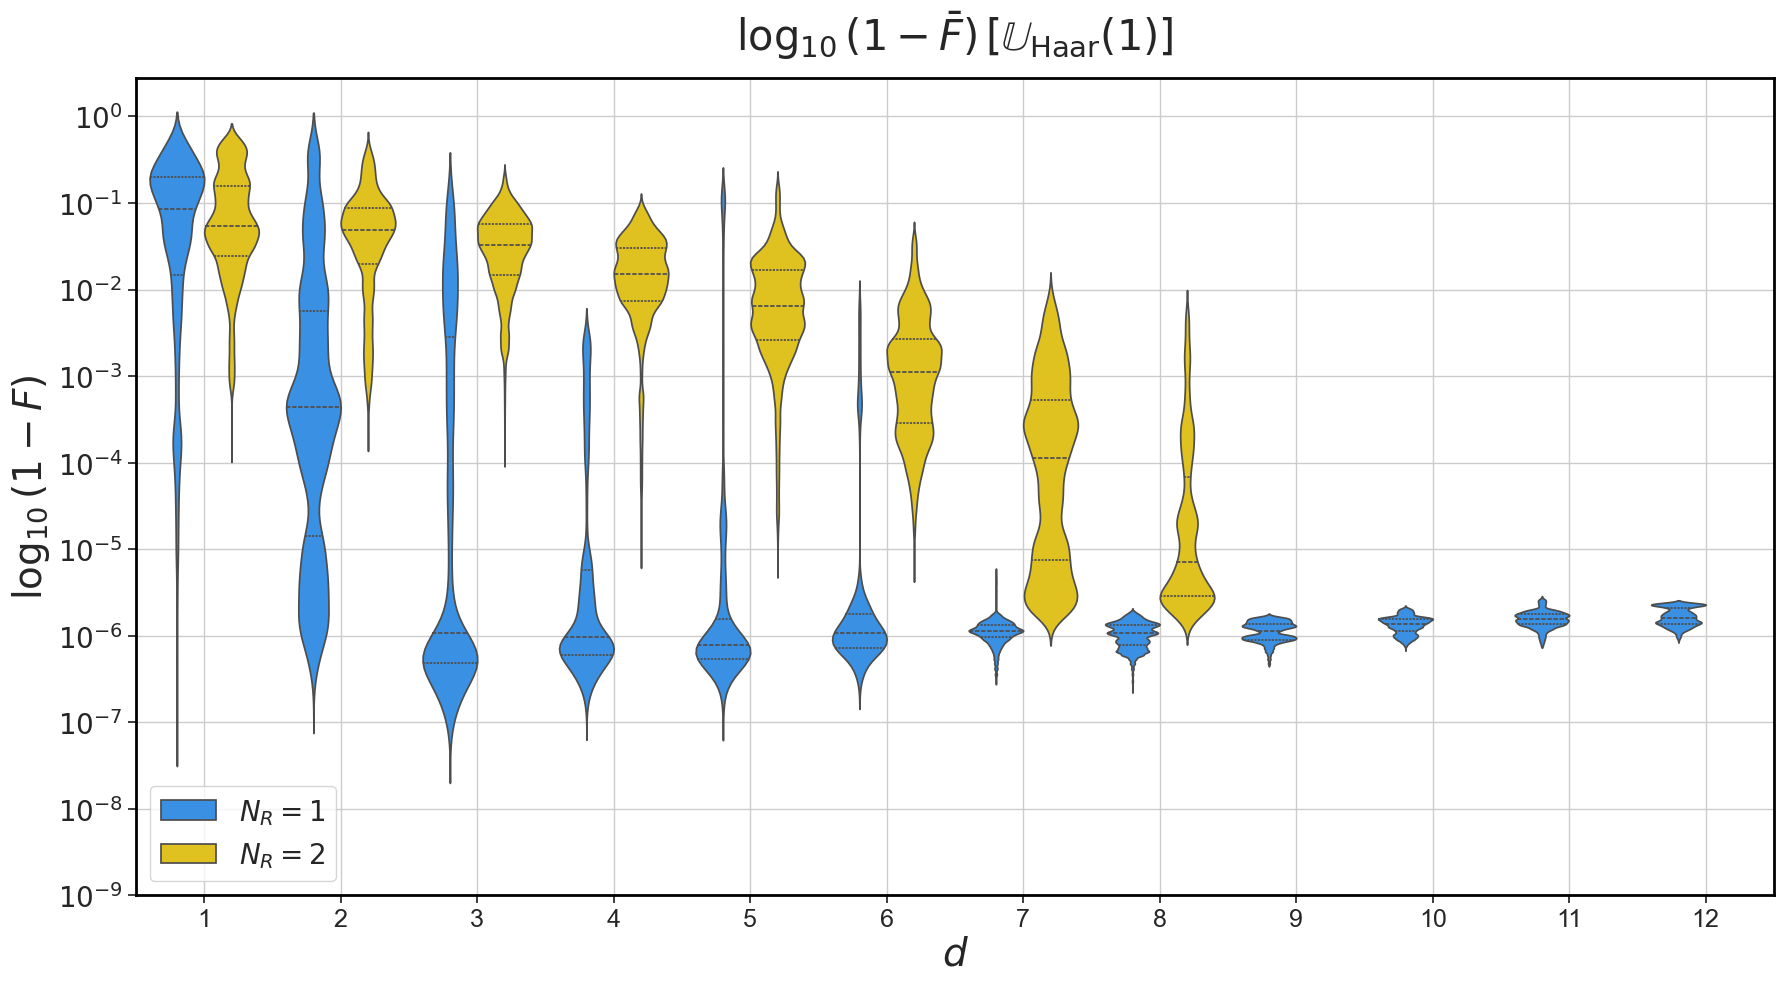

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def prepare_violin_plot_data(data_i, reservoir_counts, trots):
    """
    Function to prepare data for two violin plots:
    1. Average error (log10(1 - avg_fidelity))
    2. Error test results (log10(1 - test_results))
    """
    rows = []
    min_error = 1e-7
    jitter_scale = 1e-6
    for gate, gate_data in data_i.items():
        for reservoir_count, res_data in gate_data.items():
            for trotter_step, results_list in res_data.items():
                for results in results_list:
                    # Handle missing fidelity and other fields
                    avg_fidelity = float(results['fidelity']) if 'fidelity' in results else np.nan
                    log_infidelities = []
                    if 'test_results' in results:
                        test_results = results['test_results']
                        for fidelity in test_results:
                            if fidelity < 0:
                                negative_fidelity_values.append({
                                    'Gate': gate,
                                    'Reservoir Count': reservoir_count,
                                    'Trotter_Step': trotter_step,
                                    'Fidelity': fidelity
                                })
                            if fidelity >= 1.0:
                                # continue
                                fidelity = 1.0-1e-6
                                # fidelity = 1.0 - np.random.uniform(0, jitter_scale)
                            # infidelity = max(1.0 - fidelity, min_error)
                            log_infidelity = np.log10(infidelity)
                            log_infidelities.append(log_infidelity)
                    else:
                        test_results = []
                        log_infidelities = []

                    num_params = results.get('param_count', np.nan)
                    run = results.get('run', None)
                    # Check if avg_fidelity is NaN
                    if pd.isna(avg_fidelity):
                        print(f"NaN detected! Test: Gate: {gate}, Reservoir Count: {reservoir_count}, Trotter_Step: {trotter_step}, Run: {run}")
                    
                    # If avg_fidelity is valid, calculate log_infidelity
                    avg_log_infidelity = np.nan
                    if pd.notna(avg_fidelity) and avg_fidelity < 1.0:
                        avg_log_infidelity = np.log10(1.0 - avg_fidelity)
                    else:
                        avg_log_infidelity = np.log10(min_error)
                    # Prepare the row dictionary with all fields
                    # print(results.keys())
                    row = {
                        'N_C': N_ctrl,
                        'Trotter_Step': trotter_step,
                        'Gate': results['gate'],
                        'Reservoir Count': reservoir_count,
                        'Avg_Fidelity': avg_fidelity,
                        'Error_Test_Results': log_infidelities,
                        'Avg Error': avg_log_infidelity,
                        'Costs': results.get('costs', []),
                        'Test Results': test_results,
                        'N_params': num_params,
                        'run': run,
                    }
                    rows.append(row)

    data_df = pd.DataFrame(rows)
    
    return data_df


def plot_violin_plots(all_data_df, N_ctrl,resies):
    """
    Plot two violin plots:
    1. Average error (log10(1 - avg_fidelity))
    2. Error test results (log10(1 - test_results))
    """
    custom_palette = ['dodgerblue', 'gold', 'violet'] 
    data_df = all_data_df[
        (all_data_df['N_C'] == N_ctrl) & 
        (all_data_df['Reservoir Count'].isin(resies))
    ]


    

    # Second Violin Plot for Error_Test_Results
    test_results_df = data_df.explode('Error_Test_Results')

    fig, axs = plt.subplots(1, figsize=(18, 10)) 
    for spine in axs.spines.values():
        spine.set_linewidth(2)  # Set linewidth to 2 pixels
    sns.violinplot(x='Trotter_Step',  y='Error_Test_Results', hue='Reservoir Count', data=test_results_df, 
                   ax=axs, palette=custom_palette, density_norm='width', inner='quartile', saturation=0.75)
    axs.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
    axs.set_xlabel('$d$', fontsize=28)
    axs.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)

    axs.yaxis.grid(True)
    axs.xaxis.grid(True)
    axs.set_axisbelow(True)
    handles, labels = axs.get_legend_handles_labels()
    axs.legend(handles, [f'$N_R = {label}$' for label in labels], loc='lower left', fontsize=20)
    y_ticks = axs.get_yticks()
    whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
    axs.set_yticks(whole_y_ticks)
    axs.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

    axs.tick_params(axis='y', labelsize=20) 
    axs.tick_params(axis='x', labelsize=18) 

    plt.tight_layout()
    plt.show()


    
N_ctrl = 1

data_i = cached_data_analog[N_ctrl]
data_j = cached_data_digital[N_ctrl]

trots = np.arange(1,60,1)
data_analog_df2 = prepare_violin_plot_data(data_i, reservoir_counts, trots)
data_digital_df = prepare_violin_plot_data(data_j, reservoir_counts, trots)

plot_violin_plots(data_analog_df,N_ctrl=1,resies = [1,2])

/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_48584/3407532870.py:108: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(x='Trotter_Step',  y='Error_Test_Results', hue='Reservoir Count', data=test_results_df,


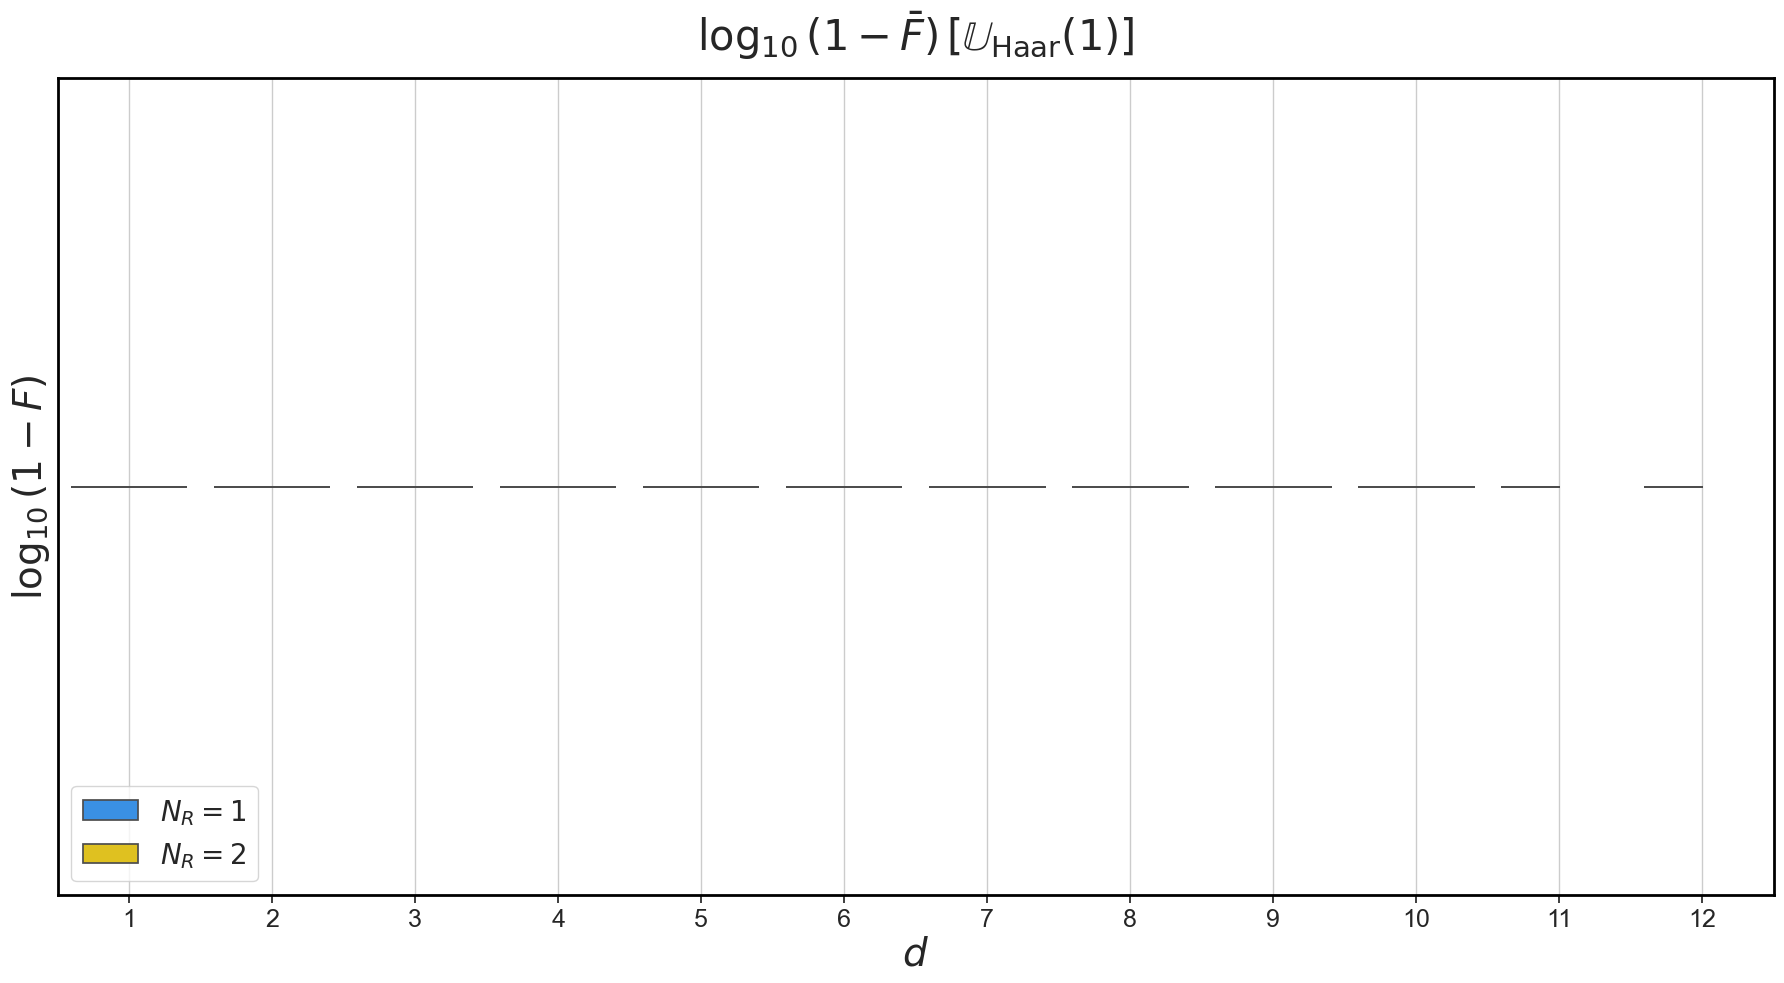

In [91]:
plot_violin_plots(data_digital_df,N_ctrl=1,resies = [1,2])

In [66]:

# Example usage:
N_ctrl = 1
N_reserv = 1
Nc = N_ctrl
digital_trots, analog_trots = find_matching_params_trotter_steps(N_ctrl, N_reserv, Nc)

# digital_trots = [1,2,3,4,5,6,7,8,9,10,12,13,14,15,16]
digital_trots = np.arange(1,60,1)
analog_trots = digital_trots
print("Matching Trotter steps for Digital model:", digital_trots)
print("Matching Trotter steps for Analog model:", analog_trots)




trot_mapping = {d: a for d, a in zip(digital_trots, analog_trots)}


data_analog_df['Type'] = 'Analog'
data_digital_df['Type'] = 'Digital'
data_analog_df


Matching Trotter steps for Digital model: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59]
Matching Trotter steps for Analog model: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59]


,Trotter_Step,Gate,Reservoir Count,Avg_Fidelity,Error_Test_Results,Avg Error,Costs,Test Results,N_params,run,Type
0,1,U1_0,1,0.909530,"[-0.885768230428539, -0.885768230428539, -1.00...",-1.043496,"[0.6633962392807007, 0.6502220034599304, 0.639...","[0.869913637638092, 0.9003381729125977, 0.8715...",5,data_run_0,Analog
1,2,U1_0,1,0.991134,"[-1.9045943899619135, -1.9045943899619135, -1....",-2.052289,"[0.5655237436294556, 0.5461202263832092, 0.530...","[0.9875432252883911, 0.9866721034049988, 0.989...",7,data_run_0,Analog
2,3,U1_0,1,0.999999,"[-6.183327210777324, -6.183327210777324, -6.22...",-6.270477,"[0.6135240793228149, 0.5840185880661011, 0.554...","[0.9999993443489075, 0.9999994039535522, 0.999...",9,data_run_0,Analog
3,4,U1_0,1,0.999999,"[-6.224719895935548, -6.224719895935548, -6.14...",-6.224720,"[0.4161183536052704, 0.3646426498889923, 0.313...","[0.9999994039535522, 0.9999992847442627, 0.999...",11,data_run_0,Analog
4,5,U1_0,1,0.999999,"[-6.048628636879868, -6.048628636879868, -6.02...",-5.969447,"[0.26664453744888306, 0.2366149127483368, 0.22...","[0.9999991059303284, 0.9999990463256836, 0.999...",13,data_run_0,Analog
...,...,...,...,...,...,...,...,...,...,...,...
547,4,U1_9,3,0.904212,"[-1.3442836179834603, -1.3442836179834603, -1....",-1.018690,"[0.5316191911697388, 0.4800300598144531, 0.457...","[0.9547398090362549, 0.930207371711731, 0.8404...",19,data_run_0,Analog
548,5,U1_9,3,0.926175,"[-1.3354658283395384, -1.3354658283395384, -0....",-1.131795,"[0.5316699147224426, 0.5100806951522827, 0.495...","[0.9538114666938782, 0.83487468957901, 0.92521...",23,data_run_0,Analog
549,6,U1_9,3,0.945261,"[-0.9326065447855876, -0.9326065447855876, -1....",-1.261706,"[0.5120787620544434, 0.4692462384700775, 0.425...","[0.8832132816314697, 0.9245327711105347, 0.888...",27,data_run_0,Analog
550,7,U1_9,3,0.993233,"[-2.176534549448844, -2.176534549448844, -2.43...",-2.169605,"[0.49464982748031616, 0.44641074538230896, 0.4...","[0.9933401346206665, 0.9963209629058838, 0.996...",31,data_run_0,Analog


In [67]:

# selected_trots = [1,2,3,4,5]
# analog_trots,digital_trots = selected_trots,selected_trots
# Step 1: Filter the analog data for the relevant analog_trots
data_analog_filtered = data_analog_df[data_analog_df['Trotter_Step'].isin(analog_trots)]

# Step 2: Filter the digital data for the relevant digital_trots
data_digital_filtered = data_digital_df[data_digital_df['Trotter_Step'].isin(digital_trots)]


In [68]:
# Concatenate the DataFrames
df_combined = pd.concat([data_digital_filtered, data_analog_filtered])

test_results_df = df_combined.explode('Error_Test_Results')
df_combined

,Trotter_Step,Gate,Reservoir Count,Avg_Fidelity,Error_Test_Results,Avg Error,Costs,Test Results,N_params,run,Type
0,1,U1_0,1,0.612785,"[-0.47301579179351544, -0.47301579179351544, -...",-0.412048,"[0.4055924117565155, 0.4040594696998596, 0.402...","[0.6635006666183472, 0.44218218326568604, 0.36...",4,data_run_0,Digital
1,2,U1_0,1,0.997911,"[-2.79622873776003, -2.79622873776003, -2.7799...",-2.680131,"[0.5950543880462646, 0.5915724635124207, 0.588...","[0.9984012842178345, 0.9983403086662292, 0.998...",5,data_run_0,Digital
2,3,U1_0,1,0.998636,"[-2.6629985343340907, -2.6629985343340907, -3....",-2.865207,"[0.5084829330444336, 0.5059584379196167, 0.503...","[0.9978272914886475, 0.9990856647491455, 0.996...",6,data_run_0,Digital
3,4,U1_0,1,1.000000,"[-7.0, -7.0, -7.0, -7.0, -6.123831109323778, -...",-7.224720,"[0.3614885210990906, 0.3580743372440338, 0.354...","[0.9999999403953552, 0.9999999403953552, 1.0, ...",7,data_run_0,Digital
4,5,U1_0,1,0.999995,"[-5.601470605537648, -5.601470605537648, -5.13...",-5.300441,"[0.4672115445137024, 0.46330901980400085, 0.45...","[0.9999974966049194, 0.9999927282333374, 0.999...",8,data_run_0,Digital
...,...,...,...,...,...,...,...,...,...,...,...
547,4,U1_9,3,0.904212,"[-1.3442836179834603, -1.3442836179834603, -1....",-1.018690,"[0.5316191911697388, 0.4800300598144531, 0.457...","[0.9547398090362549, 0.930207371711731, 0.8404...",19,data_run_0,Analog
548,5,U1_9,3,0.926175,"[-1.3354658283395384, -1.3354658283395384, -0....",-1.131795,"[0.5316699147224426, 0.5100806951522827, 0.495...","[0.9538114666938782, 0.83487468957901, 0.92521...",23,data_run_0,Analog
549,6,U1_9,3,0.945261,"[-0.9326065447855876, -0.9326065447855876, -1....",-1.261706,"[0.5120787620544434, 0.4692462384700775, 0.425...","[0.8832132816314697, 0.9245327711105347, 0.888...",27,data_run_0,Analog
550,7,U1_9,3,0.993233,"[-2.176534549448844, -2.176534549448844, -2.43...",-2.169605,"[0.49464982748031616, 0.44641074538230896, 0.4...","[0.9933401346206665, 0.9963209629058838, 0.996...",31,data_run_0,Analog


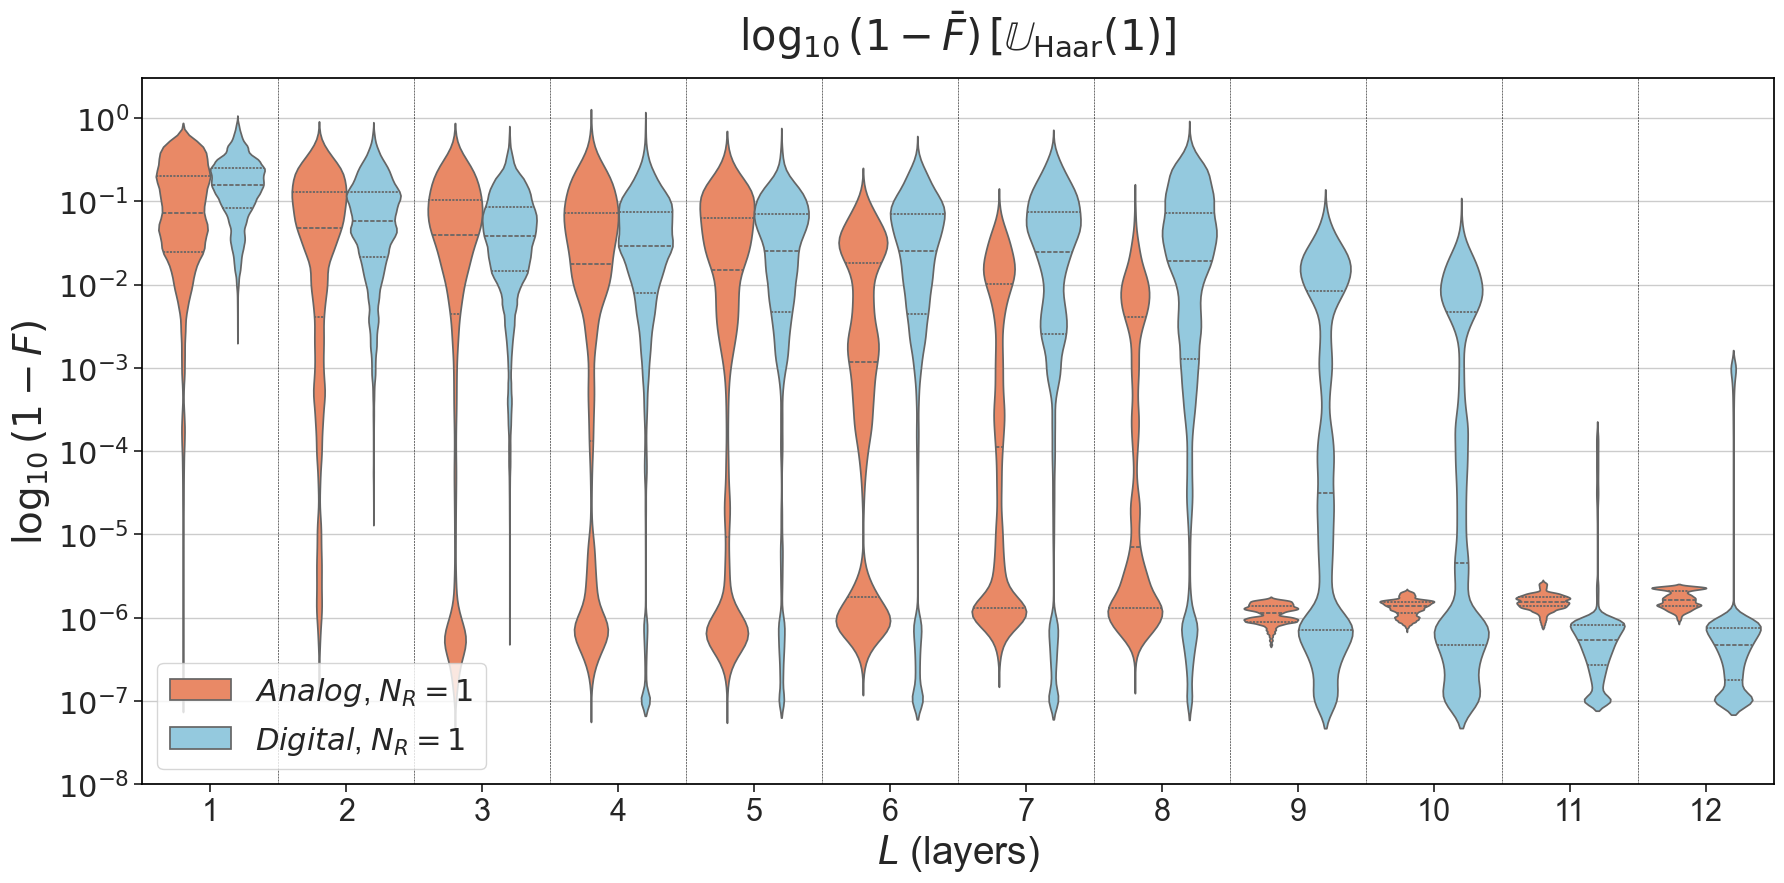

In [69]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure 'Type' has consistent categorical ordering across plots
df_combined['Type'] = pd.Categorical(df_combined['Type'], categories=['Analog', 'Digital'], ordered=True)

# Custom color palette ensuring consistent color for Analog and Digital
custom_palette = {'Analog': 'coral', 'Digital': 'skyblue'}

# Create the figure and axis for just the second plot
fig, ax = plt.subplots(1, 1, figsize=(18, 9))
sns.set_theme(style="whitegrid")  # Set a theme globally
sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})

# Explode test results into separate rows to plot each error individually
test_results_df = df_combined.explode('Error_Test_Results')

# Create the second plot: Trotter_Step vs Error_Test_Results
sns.violinplot(x='Trotter_Step', y='Error_Test_Results', hue='Type', data=test_results_df, 
               ax=ax, palette=custom_palette, density_norm='width', inner='quartile', saturation=0.75)

# Customize the second plot
ax.set_title(f'$\log_{{10}}(1 - \\bar{{F}}) \, [\\mathbb{{U}}_{{\\text{{Haar}}}}({N_ctrl})]$', fontsize=30, pad=20)
ax.set_xlabel('$L$ (layers)', fontsize=28)
ax.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)

# Customizing the legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[:2], [f'${label}$, $N_R = 1$' for label in labels[:2]], title_fontsize=16, loc='lower left', fontsize=22)

# Adjust y-tick labels
y_ticks = ax.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
min_tick = min(whole_y_ticks)
max_tick = max(whole_y_ticks)
whole_y_ticks = np.arange(min_tick, max_tick+1, 1)
ax.set_yticks(whole_y_ticks)
ax.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick parameters
ax.tick_params(axis='y', labelsize=22)
ax.tick_params(axis='x', labelsize=22)

# Use unique Trotter_Steps to match the sorted steps for vertical lines
unique_x_ticks = sorted(df_combined['Trotter_Step'].unique()) 
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    ax.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

# Final plot
plt.tight_layout()
plt.show()


In [115]:

# Example usage:
N_ctrl = 2
N_reserv = 1
Nc = N_ctrl
digital_trots, analog_trots = find_matching_params_trotter_steps(N_ctrl, N_reserv, Nc)

def get_n_params(type_model, Nr, steps, Nc):
    # print(type_model)
    if type_model:  # Analog model
        return steps * Nr * Nc + steps + 3
    else:  # Digital model
        return steps * Nr * Nc + 3
    
def get_steps(type_model, Nr, Nc, num_params):
    if type_model:  # Analog model
        return -3+ (num_params - Nc) // (Nr * Nc) 
    else:  # Digital model
        return -3+ num_params // (Nr * Nc)


digital_num_params = [get_n_params(0,1,t, N_ctrl) for t in digital_trots]
analog_num_params = [get_n_params(1,1,t, N_ctrl) for t in analog_trots]
print(f"digital_trots: {digital_trots}")
print(f"digital_num_params: {digital_num_params}")
print(f"\nanalog_trots: {analog_trots}")
print(f"analog_num_params: {analog_num_params}")

digital_trots: [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57]
digital_num_params: [9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 81, 87, 93, 99, 105, 111, 117]

analog_trots: [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]
analog_num_params: [9, 15, 21, 27, 33, 39, 45, 51, 57, 63, 69, 75, 81, 87, 93, 99, 105, 111, 117]


In [251]:
get_n_params(0,1,36,3)

108

In [17]:
analog_trots[-15]

10

In [14]:
df_combined

,Trotter Step,Gate,Reservoir Count,Avg_Fidelity,Error Test Results,Avg Error,Costs,Test Results,N_params,run,Type
0,4,U3_0,1,0.204146,"[-0.058542676082558726, -0.058542676082558726,...",-0.099166,"[0.8633778095245361, 0.852660059928894, 0.8434...","[0.12610888481140137, 0.3166089653968811, 0.26...",15,data_run_0,Digital
1,8,U3_0,1,0.333583,"[-0.12697104597382905, -0.12697104597382905, -...",-0.176254,"[0.8847211003303528, 0.8654912710189819, 0.851...","[0.2535014748573303, 0.1863541603088379, 0.520...",27,data_run_0,Digital
2,12,U3_0,1,0.489303,"[-0.3528127289815557, -0.3528127289815557, -0....",-0.291837,"[0.8531605005264282, 0.825212299823761, 0.7981...","[0.5562000274658203, 0.5152520537376404, 0.582...",39,data_run_1,Digital
3,16,U3_0,1,0.707393,"[-0.4385202788408737, -0.4385202788408737, -0....",-0.533716,"[0.8401942253112793, 0.8179594874382019, 0.797...","[0.6356827616691589, 0.8234061598777771, 0.658...",51,data_run_0,Digital
4,20,U3_0,1,0.712138,"[-0.5284161150721148, -0.5284161150721148, -0....",-0.540816,"[0.8547841906547546, 0.8223100304603577, 0.795...","[0.7038007974624634, 0.5528959631919861, 0.750...",63,data_run_0,Digital
...,...,...,...,...,...,...,...,...,...,...,...
249,36,U3_9,1,0.999000,"[-3.1325257752382325, -3.1325257752382325, -3....",-3.000083,"[0.8248881101608276, 0.7894620895385742, 0.757...","[0.9992629885673523, 0.999347448348999, 0.9990...",147,data_run_0,Analog
250,44,U3_9,1,0.999995,"[-5.373461547216474, -5.373461547216474, -5.31...",-5.327093,"[0.8489999771118164, 0.8102181553840637, 0.786...","[0.999995768070221, 0.9999951720237732, 0.9999...",179,data_run_0,Analog
251,48,U3_9,1,0.999996,"[-5.361397035815092, -5.361397035815092, -5.35...",-5.361397,"[0.8810553550720215, 0.8433611392974854, 0.809...","[0.9999956488609314, 0.9999955892562866, 0.999...",195,data_run_0,Analog
252,52,U3_9,1,0.999995,"[-5.300440609873667, -5.300440609873667, -5.29...",-5.285201,"[0.8681173920631409, 0.8240969777107239, 0.780...","[0.9999949932098389, 0.9999948740005493, 0.999...",211,data_run_0,Analog


/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_35082/1626453026.py:14: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(x='Trotter Step', y='Avg Error',  hue='Type', data=df_combined,
/var/folders/xx/w2tzbky134bg3g8mct87xb8c0000gn/T/ipykernel_35082/1626453026.py:52: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.violinplot(x='N_params', y='Avg Error',  hue='Type', data=df_combined,


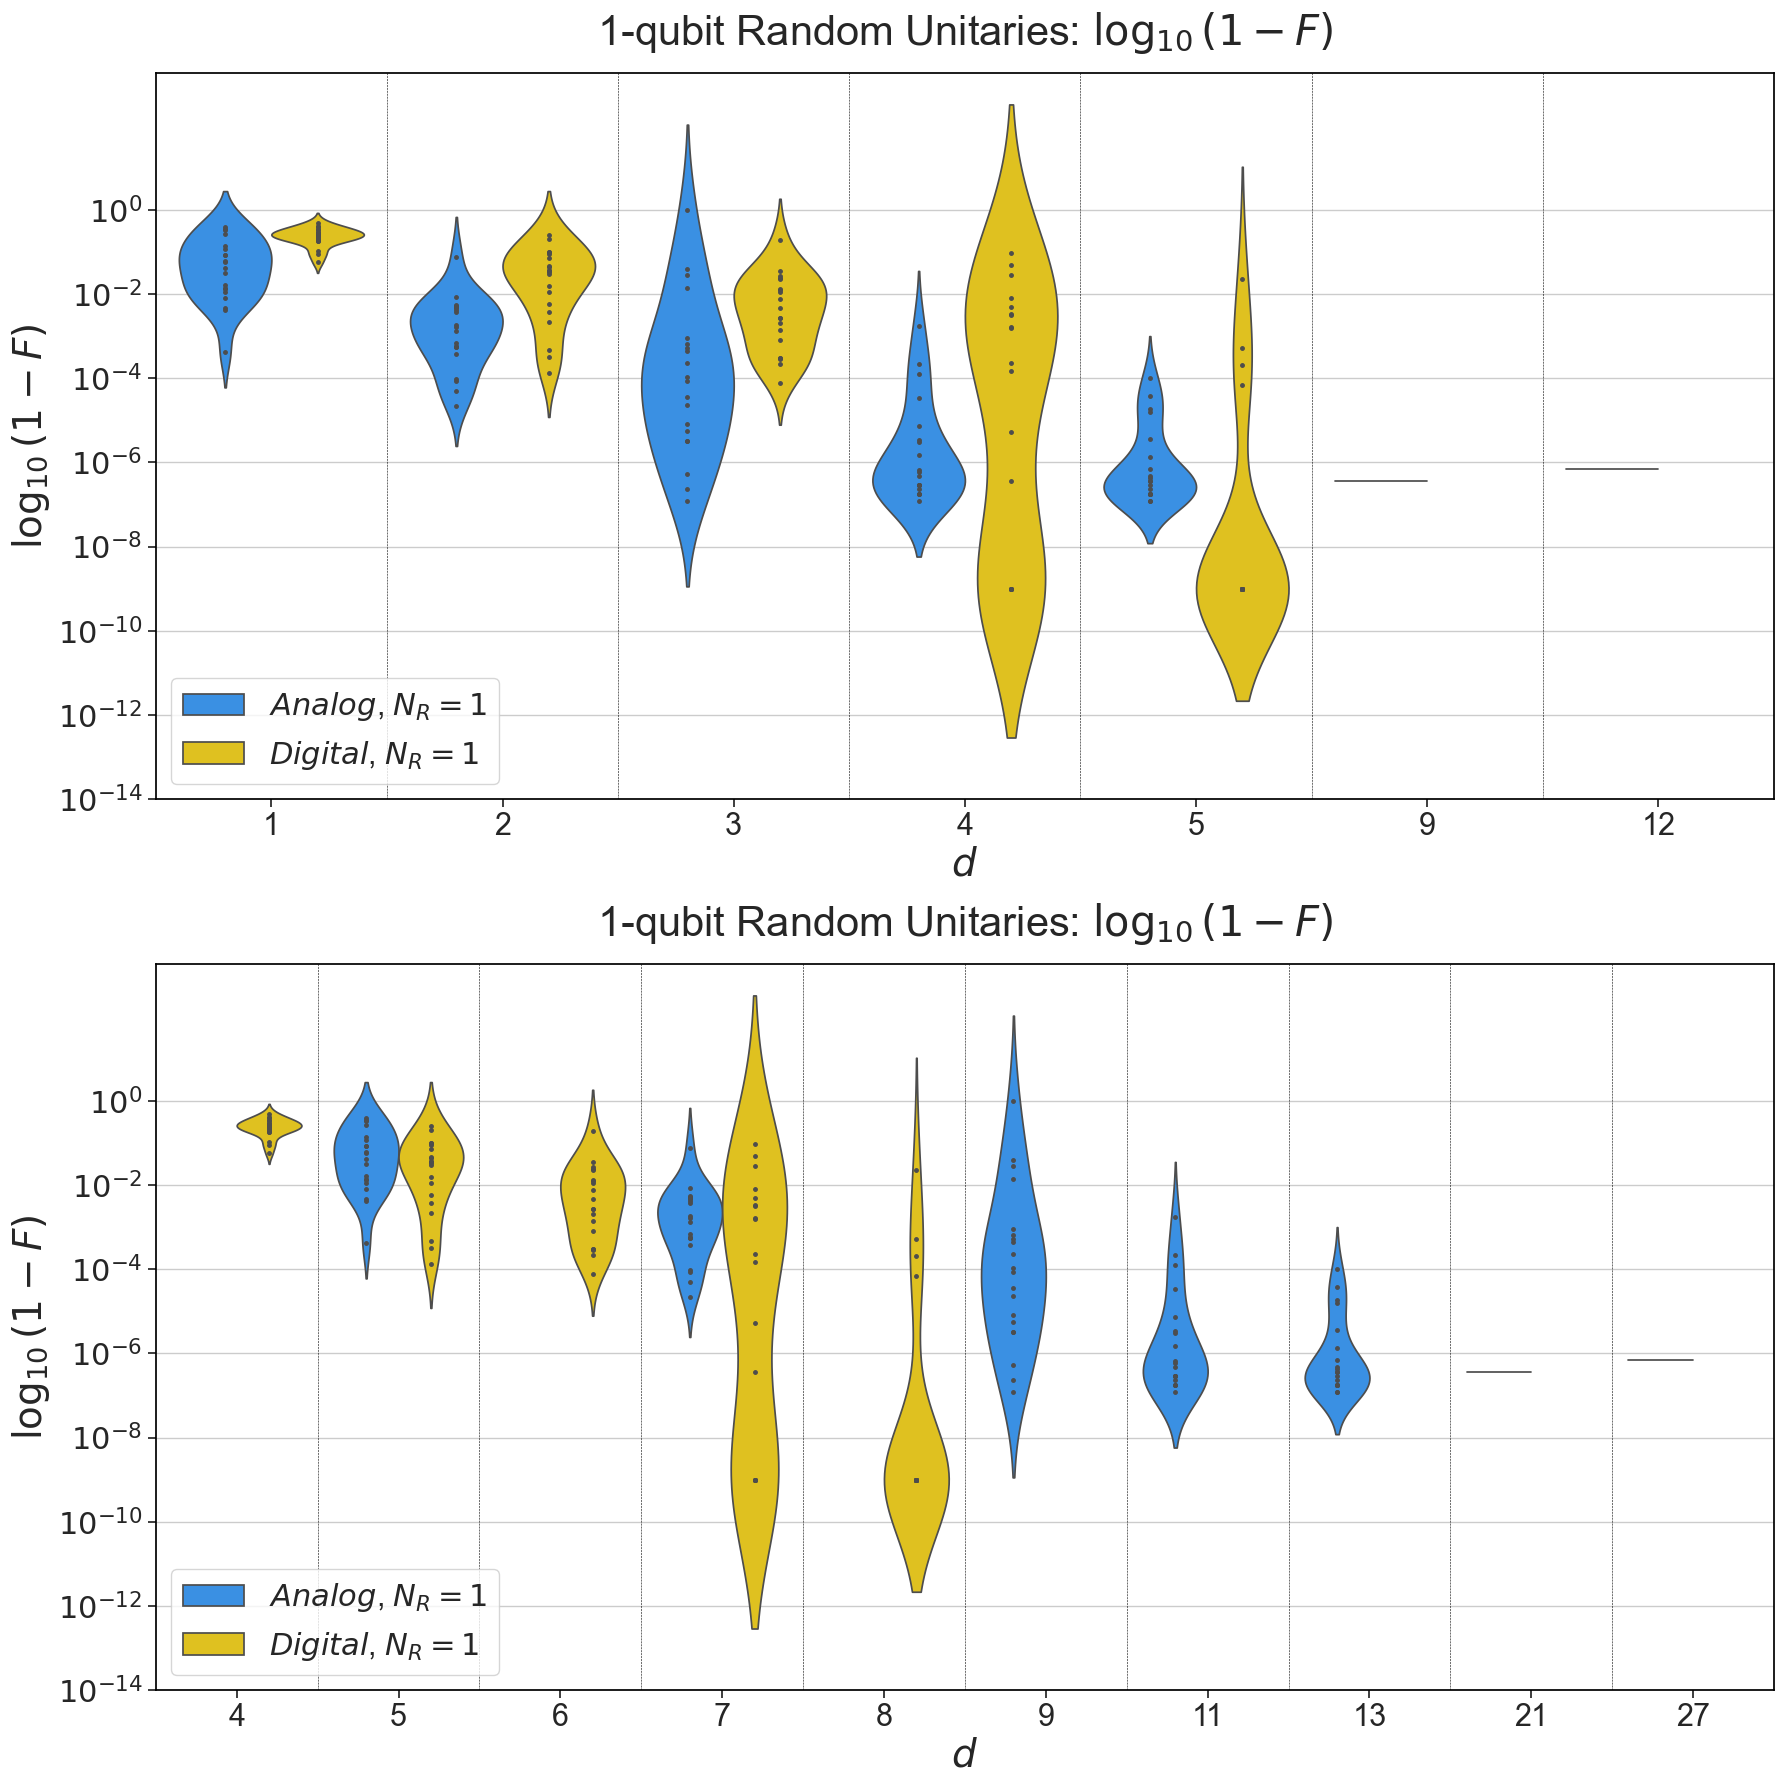

In [97]:

custom_palette = ['dodgerblue', 'gold', 'violet'] 


fig, axs2 = plt.subplots(2,1, figsize=(18, 18))
sns.set_theme(style="whitegrid", palette=custom_palette)  # Set a theme globally
sns.set_style("whitegrid", {'axes.grid': True, 'axes.edgecolor': 'black', 'xtick.bottom': True, 'ytick.left': True})

violin_axs_avg = axs2[0]

# # Add another layer for the type (Gate/Analog) with different hatch patterns
# sns.violinplot(x='N_params', y='Error_Test_Results', hue='Type', data=test_results_df, ax=violin_axs_log,
#                palette=custom_palette, linewidth=1, density_norm='width', inner='quartile')

sns.violinplot(x='Trotter_Step', y='Avg Error',  hue='Type', data=df_combined, 
                   ax=violin_axs_avg, palette=custom_palette, density_norm='width', inner="point")

# Customize the plot
violin_axs_avg.yaxis.grid(True)
violin_axs_avg.xaxis.grid(False)
violin_axs_avg.set_axisbelow(True)
violin_axs_avg.set_title(f'{N_ctrl}-qubit Random Unitaries: $\log_{{10}}(1 - F)$', fontsize=30, pad=20)
violin_axs_avg.set_xlabel('$d$', fontsize=28)
violin_axs_avg.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)

# Customizing the legend
handles, labels = violin_axs_avg.get_legend_handles_labels()
violin_axs_avg.legend(handles[:2], [f'${label}$, $N_R = 1$' for label in labels[:2]], title_fontsize=16, loc='lower left', fontsize=22)

# Adjust y-tick labels
y_ticks = violin_axs_avg.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
violin_axs_avg.set_yticks(whole_y_ticks)
violin_axs_avg.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick parameters
violin_axs_avg.tick_params(axis='y', labelsize=22)
violin_axs_avg.tick_params(axis='x', labelsize=22)

# Use len(unique_trotter_steps) to match the sorted steps for vertical lines
unique_x_ticks = sorted(test_results_df['Trotter_Step'].unique()) 
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    violin_axs_avg.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)


violin_axs_avg = axs2[1]

# # Add another layer for the type (Gate/Analog) with different hatch patterns
# sns.violinplot(x='N_params', y='Error_Test_Results', hue='Type', data=test_results_df, ax=violin_axs_log,
#                palette=custom_palette, linewidth=1, density_norm='width', inner='quartile')

sns.violinplot(x='N_params', y='Avg Error',  hue='Type', data=df_combined, 
                   ax=violin_axs_avg, palette=custom_palette, density_norm='width', inner="point")

# Customize the plot
violin_axs_avg.yaxis.grid(True)
violin_axs_avg.xaxis.grid(False)
violin_axs_avg.set_axisbelow(True)
violin_axs_avg.set_title(f'{N_ctrl}-qubit Random Unitaries: $\log_{{10}}(1 - F)$', fontsize=30, pad=20)
violin_axs_avg.set_xlabel('$d$', fontsize=28)
violin_axs_avg.set_ylabel(r'$\log_{10}(1 - F)$', fontsize=28)

# Customizing the legend
handles, labels = violin_axs_avg.get_legend_handles_labels()
violin_axs_avg.legend(handles[:2], [f'${label}$, $N_R = 1$' for label in labels[:2]], title_fontsize=16, loc='lower left', fontsize=22)

# Adjust y-tick labels
y_ticks = violin_axs_avg.get_yticks()
whole_y_ticks = [tick for tick in y_ticks if tick == int(tick) and tick <= 0]
violin_axs_avg.set_yticks(whole_y_ticks)
violin_axs_avg.set_yticklabels([f'$10^{{{int(tick)}}}$' for tick in whole_y_ticks])

# Adjust tick parameters
violin_axs_avg.tick_params(axis='y', labelsize=22)
violin_axs_avg.tick_params(axis='x', labelsize=22)

# Use len(unique_trotter_steps) to match the sorted steps for vertical lines
unique_x_ticks = sorted(test_results_df['N_params'].unique()) 
positions = range(1, len(unique_x_ticks), 1)
for pos in positions:
    violin_axs_avg.axvline(x=pos - 0.5, color='black', linestyle='--', linewidth=0.4)

plt.tight_layout()
plt.show()



In [27]:
df_combined

,Trotter Step,Gate,Reservoir Count,Avg_Fidelity,Error Test Results,Avg Error,Costs,Test Results,N_params,run,Type
0,1,U1_0,1,0.595487,"[-0.0967903732181078, -0.0967903732181078, -0....",-0.393068,"[0.6637874841690063, 0.6478947997093201, 0.630...","[0.19977958500385284, 0.17161035537719727, 0.2...",4,data_run_0,Digital
1,2,U1_0,1,0.997801,"[-2.8079961983888144, -2.8079961983888144, -3....",-2.657764,"[0.43177130818367004, 0.4061225652694702, 0.38...","[0.9984440207481384, 0.9991700649261475, 0.996...",5,data_run_0,Digital
2,3,U1_0,1,0.998596,"[-2.974763713976868, -2.974763713976868, -2.63...",-2.852526,"[0.5744995474815369, 0.5428612232208252, 0.511...","[0.9989401698112488, 0.9976838231086731, 0.997...",6,data_run_0,Digital
3,4,U1_0,1,1.000000,"[-5.306743752813469, -5.306743752813469, -5.41...",-9.000000,"[0.5836142897605896, 0.5690334439277649, 0.553...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",7,data_run_0,Digital
4,5,U1_0,1,1.000000,"[-5.006673144833501, -5.006673144833501, -5.08...",-9.000000,"[0.34217169880867004, 0.3050709664821625, 0.26...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...",8,data_run_0,Digital
...,...,...,...,...,...,...,...,...,...,...,...
97,1,U1_9,1,0.866943,"[-0.8863124126387096, -0.8863124126387096, -0....",-0.875963,"[0.6424397230148315, 0.62864089012146, 0.61497...","[0.8700765371322632, 0.863301694393158, 0.7847...",5,data_run_1,Analog
98,2,U1_9,1,0.923770,"[-1.2107003026740872, -1.2107003026740872, -1....",-1.117876,"[0.44510775804519653, 0.4189179837703705, 0.38...","[0.9384398460388184, 0.9152995347976685, 0.960...",7,data_run_3,Analog
99,3,U1_9,1,0.991365,"[-1.9071746825658844, -1.9071746825658844, -2....",-2.063726,"[0.6319380402565002, 0.6137701272964478, 0.594...","[0.987617015838623, 0.9986125826835632, 0.9862...",9,data_run_3,Analog
100,4,U1_9,1,1.000000,"[-6.52574989159953, -6.52574989159953, -6.5257...",-6.525750,"[0.6167646050453186, 0.6004236936569214, 0.582...","[0.9999997019767761, 0.9999997019767761, 0.999...",11,data_run_0,Analog


### <b>Plot Together</b>


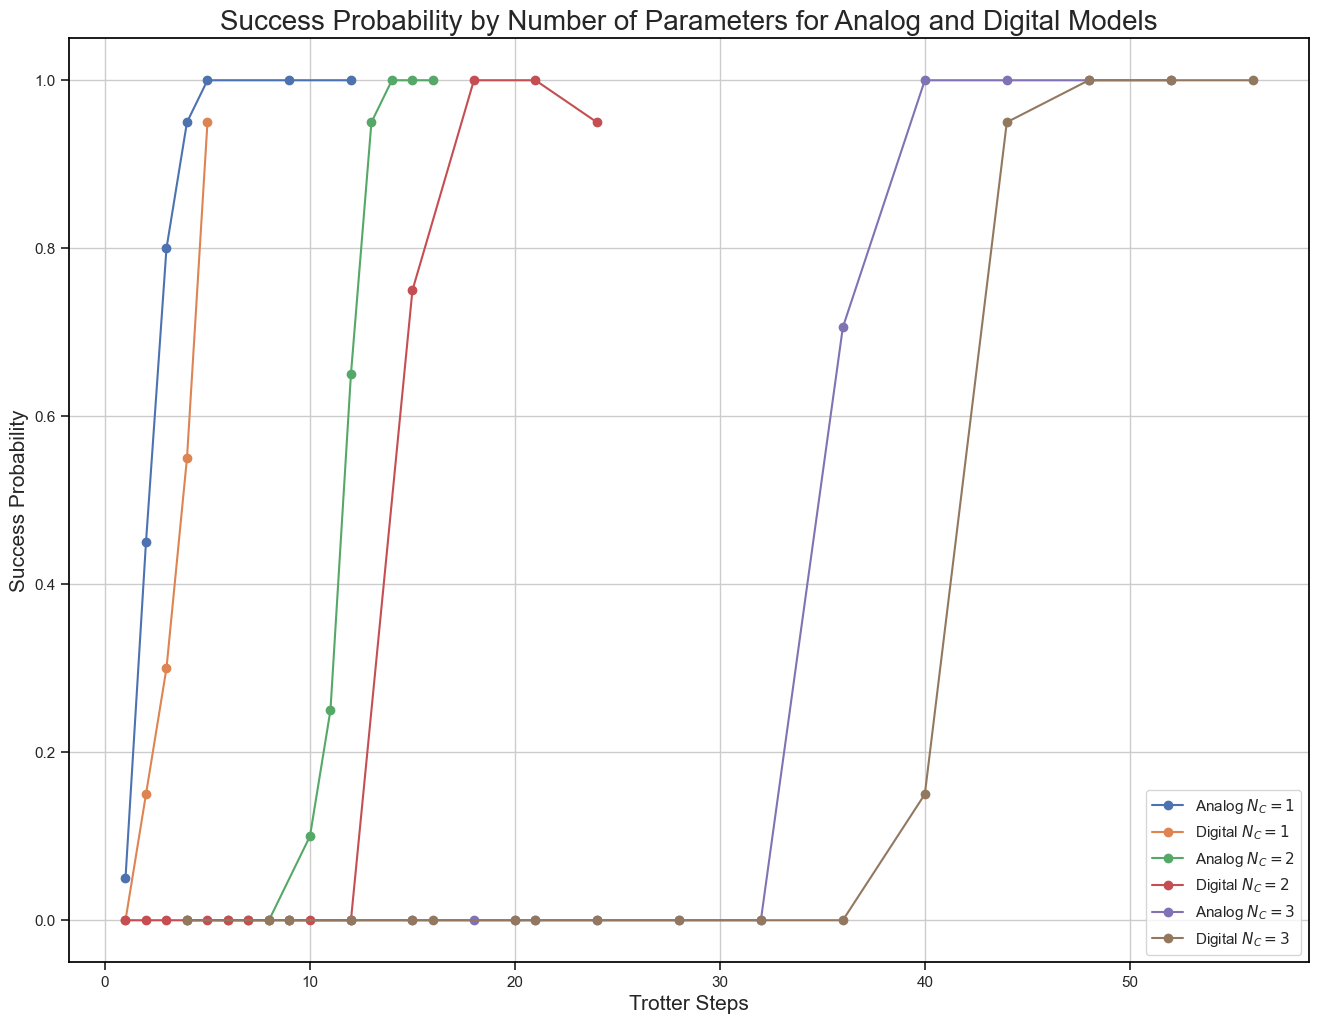

In [28]:

# Initialize an empty list for combined data from all N_ctrl values
all_dfs_combined = []
custom_palette = ['dodgerblue', 'gold', 'violet'] 
# Loop through N_ctrl values
for N_ctrl in [1, 2, 3]:

    trots_dig, trots_analog = find_matching_params_trotter_steps(N_ctrl, 1, N_ctrl)
    # Access analog and digital data for the current N_ctrl value
    data_i = cached_data_analog[N_ctrl]
    data_j  = cached_data_digital[N_ctrl]


    trots = np.arange(1,60,1)
    data_analog_df = prepare_violin_plot_data(data_i, reservoir_counts, trots)
    data_digital_df = prepare_violin_plot_data(data_j, reservoir_counts, trots)



    # Add 'Type' column to distinguish between analog and digital
    data_analog_df['Type'] = 'Analog'
    data_digital_df['Type'] = 'Digital'
    data_analog_df['N_C'] = N_ctrl
    data_digital_df['N_C'] = N_ctrl
    # Append the data to the combined DataFrame list
    all_dfs_combined.append(pd.concat([data_analog_df, data_digital_df]))


# Concatenate all DataFrames for all N_ctrl values
df_combined = pd.concat(all_dfs_combined)

# Define success criteria (infidelity less than a threshold)
success_threshold = 0.999  # Corresponds to fidelity > 0.99

# Initialize the plot
plt.figure(figsize=(16, 12))

# Group the data by N_C, Type, and Trotter_Step for both analog and digital
for N_ctrl in [1, 2, 3]:
    for model_type in ['Analog', 'Digital']:
        # Filter the combined DataFrame for the current N_ctrl and model type
        df_filtered = df_combined[(df_combined['N_C'] == N_ctrl) & (df_combined['Type'] == model_type)]
        
        # Filter for reservoir count = 1 (or adjust as needed)
        df_filtered = df_filtered[df_filtered['Reservoir Count'] == 1]
        # print(df_filtered.head())
        # Group by number of parameters and calculate success probability
        success_probabilities = df_filtered.groupby('Trotter_Step').apply(
            lambda group: np.mean(group['Avg_Fidelity'] > success_threshold)
        ).reset_index(name='Success Probability')
        
        # Plot success probability for this value of N_ctrl and model type
        plt.plot(success_probabilities['Trotter_Step'], 
                 success_probabilities['Success Probability'], 
                 marker='o', 
                 label=f'{model_type} $N_C = {N_ctrl}$')

# Set titles and labels
plt.title('Success Probability by Number of Parameters for Analog and Digital Models', fontsize=20)
plt.xlabel('Trotter_Steps', fontsize=15)
plt.ylabel('Success Probability', fontsize=15)

# Add a legend to differentiate the curves
plt.legend()

# Show the plot
plt.show()
# Initialize the plot


In [29]:
df_combined

,Trotter Step,Gate,Reservoir Count,Avg_Fidelity,Error Test Results,Avg Error,Costs,Test Results,N_params,run,Type,N_C
0,1,U1_0,1,0.916424,"[-2.108288163202302, -2.108288163202302, -1.05...",-1.077920,"[0.6262561678886414, 0.6200692057609558, 0.612...","[0.992206871509552, 0.9123387932777405, 0.8859...",5,data_run_0,Analog,1
1,2,U1_0,1,0.999599,"[-3.3043878243959592, -3.3043878243959592, -3....",-3.396769,"[0.5422753095626831, 0.533820629119873, 0.5260...","[0.9995038509368896, 0.9994884729385376, 0.999...",7,data_run_3,Analog,1
2,3,U1_0,1,0.999965,"[-4.360802518977688, -4.360802518977688, -4.55...",-4.457564,"[0.584880530834198, 0.5540993213653564, 0.5188...","[0.9999564290046692, 0.9999721050262451, 0.999...",9,data_run_1,Analog,1
3,4,U1_0,1,1.000000,"[-6.622659904607587, -6.622659904607587, -6.62...",-6.622660,"[0.6582514643669128, 0.6345961093902588, 0.607...","[0.9999997615814209, 0.9999997615814209, 0.999...",11,data_run_0,Analog,1
4,5,U1_0,1,0.999996,"[-6.078591860257311, -6.078591860257311, -6.62...",-5.439390,"[0.5874279737472534, 0.5755998492240906, 0.561...","[0.9999991655349731, 0.9999997615814209, 0.999...",13,data_run_0,Analog,1
...,...,...,...,...,...,...,...,...,...,...,...,...
305,44,U3_9,1,0.999768,"[-3.6960602507005587, -3.6960602507005587, -3....",-3.634994,"[0.9167177081108093, 0.8797635436058044, 0.849...","[0.9997986555099487, 0.9997289776802063, 0.999...",135,data_run_0,Digital,3
306,48,U3_9,1,1.000000,"[-6.747598641215887, -6.747598641215887, -6.52...",-6.747599,"[0.8929747343063354, 0.8483092188835144, 0.802...","[0.9999998211860657, 0.9999997019767761, 0.999...",147,data_run_0,Digital,3
307,52,U3_9,1,0.999999,"[-6.183327210777324, -6.183327210777324, -6.02...",-5.945966,"[0.8517856597900391, 0.8124060034751892, 0.780...","[0.9999993443489075, 0.9999990463256836, 0.999...",159,data_run_0,Digital,3
308,56,U3_9,1,1.000000,"[-5.266715689277418, -5.266715689277418, -7.22...",-7.224720,"[0.8273468017578125, 0.7933394908905029, 0.763...","[1.0, 0.9999999403953552, 1.0, 0.9999999403953...",171,data_run_0,Digital,3


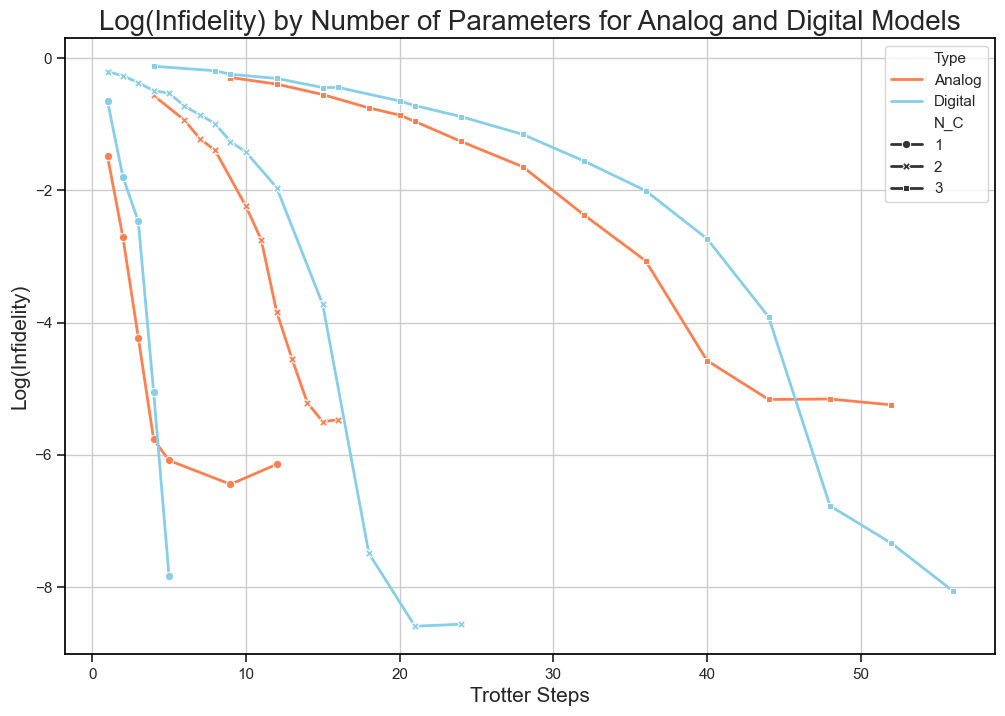

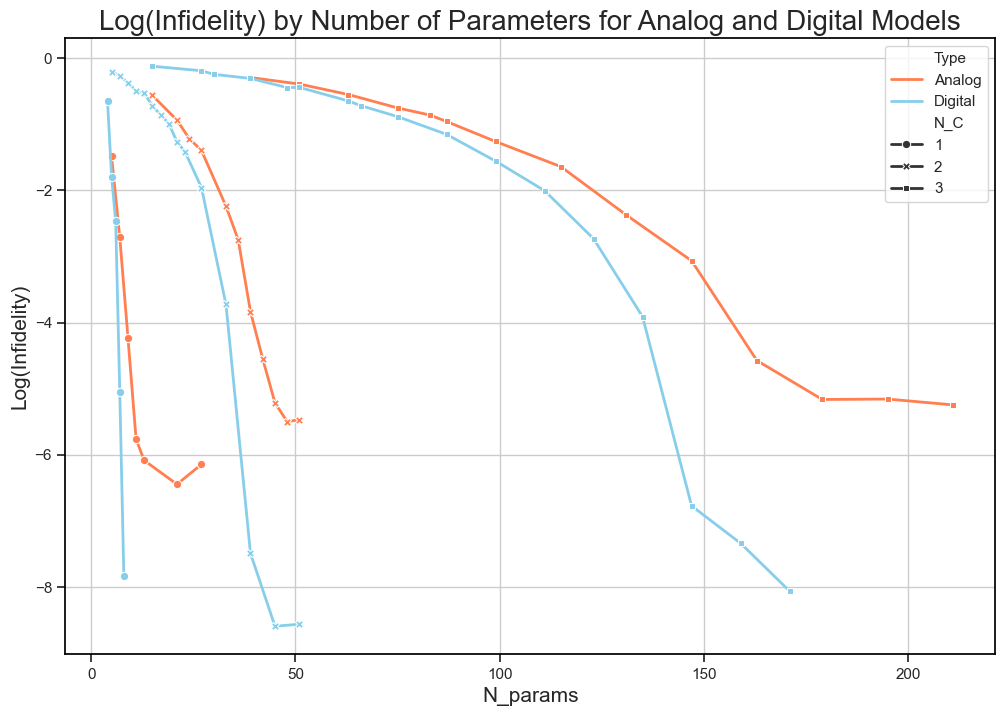

In [31]:
plt.figure(figsize=(12, 8))

# Group by num_params, Type, and N_C, and aggregate the Log(Infidelity) by taking the mean
df_combined_agg = df_combined.groupby(['Trotter_Step', 'Type', 'N_C', 'Reservoir Count','N_params']).agg({
    'Avg Error': 'mean'
}).reset_index()

df_combined_agg
# Use Seaborn's lineplot to plot the aggregated Log(Infidelity) over the number of parameters
sns.lineplot(
    x='Trotter_Step', 
    y='Avg Error', 
    hue='Type', 
    style='N_C',  # Style by N_ctrl value (1, 2, 3)
    markers=True, 
    dashes=False, 
    data=df_combined_agg,
    palette={'Analog': 'coral', 'Digital': 'skyblue'},
    linewidth=2
)

# Set titles and labels
plt.title('Log(Infidelity) by Number of Parameters for Analog and Digital Models', fontsize=20)
plt.xlabel('Trotter_Steps', fontsize=15)
plt.ylabel('Log(Infidelity)', fontsize=15)

# Customize legend
plt.legend()

# Show the plot
plt.show()

# # df_filtered3 = df_combined2[df_combined2['N_C'] == 1]
# df_combined_anparams = df_filtered3.groupby(['N_param', 'Type', 'N_C']).agg({
#     'Infidelity': 'mean'
# }).reset_index()




# Initialize the plot
plt.figure(figsize=(12, 8))

# Use Seaborn's lineplot to plot the aggregated Log(Infidelity) over the number of parameters
sns.lineplot(
    x='N_params', 
    y='Avg Error', 
    hue='Type', 
    style='N_C',  # Style by N_ctrl value (1, 2, 3)
    markers=True, 
    dashes=False, 
    data=df_combined_agg,
    palette={'Analog': 'coral', 'Digital': 'skyblue'},
    linewidth=2
)

# Set titles and labels
plt.title('Log(Infidelity) by Number of Parameters for Analog and Digital Models', fontsize=20)
plt.xlabel('N_params', fontsize=15)
plt.ylabel('Log(Infidelity)', fontsize=15)

# Customize legend
plt.legend()

# Show the plot
plt.show()


In [ ]:
Error_Test_Results